# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az

df = pd.read_csv("data/data_stats_filtered.csv", index_col=0)
df["region_name_id"] = pd.factorize(df["region_name"])[0]
print(f"N = {df.shape[0]}")
df.sample(5)

N = 3228


year       region_name  population_interpolated        N_est  \
322   1684    Eastern Europe                  16.6900  3588.250381   
2402  1663  Nordic countries                   2.1280  1712.607250   
1700  1496     Low countries                   2.1200   673.456503   
2682  1295    United Kingdom                   4.1775   194.056363   
2908  1521    United Kingdom                   4.3970   718.043455   

            lower        upper  score  score_cap   lower_cap   N_est_cap  \
322   3194.520214  3995.734631  157.8   9.470173  191.722827  215.354096   
2402  1476.262823  1967.242440   87.1  41.000502  694.632112  805.865100   
1700   583.573069   770.222562   87.8  41.112917  273.177876  315.267226   
2682   126.999703   271.167592   12.5   2.957799   30.048465   45.916302   
2908   601.894666   843.062573   50.6  11.509393  136.939321  163.366147   

       upper_cap  gdp_per_capita  inclusive  restricted  region_name_id  
322   239.811845            1041          1           1               1  
2402  925.704049            1639          1           1               7  
1700  360.579100            2278          1           1               6  
2682   64.163411            1155          1           1               9  
2908  191.811492            1791          1           1               9

We have GDP data for the following 10 regions:

In [3]:
df["region_name"].value_counts()

United Kingdom      590
Nordic countries    541
France              532
Italy               532
Low countries       487
Eastern Europe      423
Spain                58
Chinese world        46
Japan                12
German world          7
Name: region_name, dtype: int64

We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

In [4]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])
df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df.sample(5)

year       region_name  population_interpolated        N_est  \
294   1656    Eastern Europe                   15.710  3249.811076   
817   1627            France                   19.850  2169.030654   
1368  1669             Italy                   11.760  4053.765401   
2475  1736  Nordic countries                    2.782  4219.827965   
914   1724            France                   22.960  3809.907199   

            lower        upper  score  score_cap    lower_cap    N_est_cap  \
294   2875.646699  3630.926879  145.0   9.218927   182.940881   206.748587   
817   2000.805621  2344.415868  218.7  11.032308   100.917049   109.404414   
1368  3694.307160  4409.408946  237.4  20.203687   314.351695   344.935900   
2475  3731.880695  4740.557013  203.0  72.889312  1338.708571  1513.795418   
914   3595.518328  4036.680156  475.6  20.715064   156.586289   165.923666   

      ...  score_log  score_cap_log  N_est_log  N_est_cap_log  score_log_std  \
294   ...   4.976734       2.221259   8.086352       5.331504       1.150587   
817   ...   5.387701       2.400828   7.682036       4.695051       1.245599   
1368  ...   5.469746       3.005865   8.307401       5.843359       1.264568   
2475  ...   5.313206       4.288942   8.347550       7.322375       1.228377   
914   ...   6.164577       3.030861   8.245360       5.111528       1.425208   

      score_cap_log_std  N_est_log_std  N_est_cap_log_std   log_gdp  \
294            0.921854       1.196264           1.100652  6.853299   
817            0.996378       1.136451           0.969261  7.404279   
1368           1.247477       1.228965           1.206321  7.890957   
2475           1.779973       1.234905           1.511653  7.399398   
914            1.257851       1.219787           1.055239  7.444249   

      log_gdp_std  
294      0.912581  
817      0.985950  
1368     1.050755  
2475     0.985300  
914      0.991272  

[5 rows x 26 columns]

The distribution of the logged GDP values is clearly trimodal:

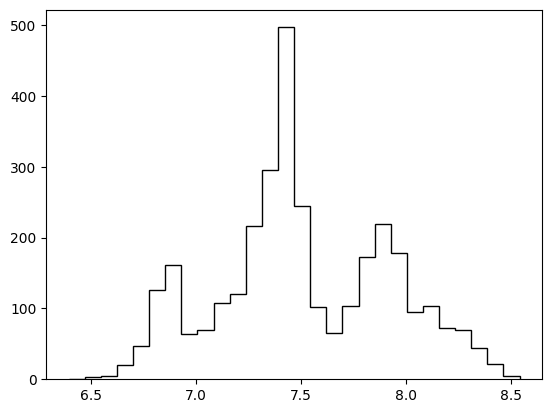

In [5]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

We observe an intriguing trimodal structure. It was suggested by Charles that this might be due to "the fact that the Maddison data always tend to have an estimation for a region at date year=1 and then jump up to over year=1000". Filtering these instances, doesn't seem to alter the trimodal structure, however:

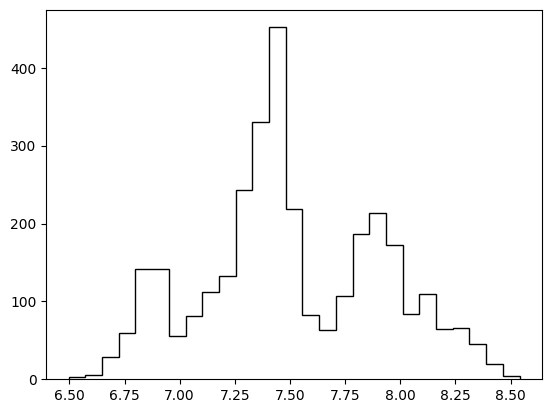

In [6]:
plt.hist(df.loc[df["year"] >= 1000, "log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

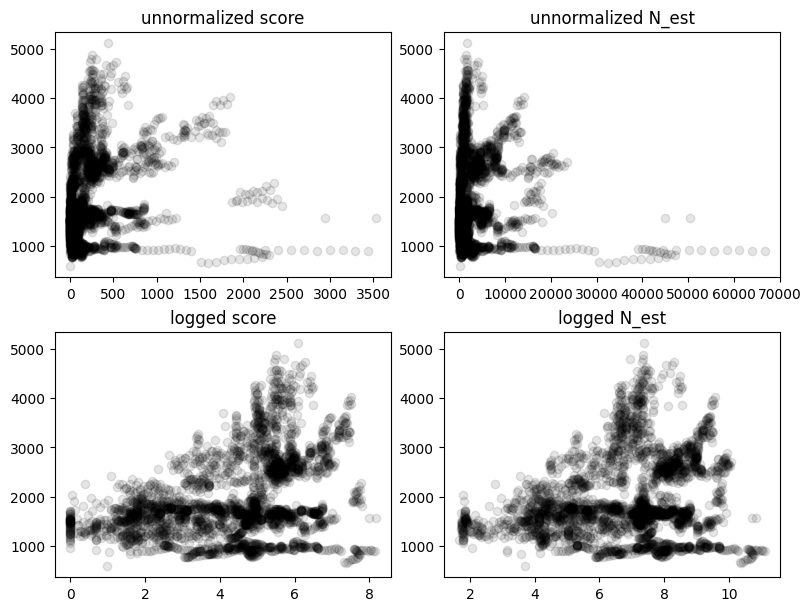

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

## Regression Analysis: Setting a Baseline

In our attempt to model the relationship between per capita GDP and cultural production, we utilize linear regression models. By progressively developing more intricate models, we evaluate them via approximate leave-one-out cross-validation (LOO). Initially, we establish a global relationship model that doesn't account for any regional differentiation. The model is specified as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In this model, $\alpha$ stands for the intercept and $\beta$ denotes the coefficient of the production score.

In [8]:
models = {}

The model is easily translated to Bambi with:

In [9]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score = bmb.Model(
    f"log_gdp_std ~ score_log_std", df, family="gaussian", priors=priors)

The model graph looks as follows:

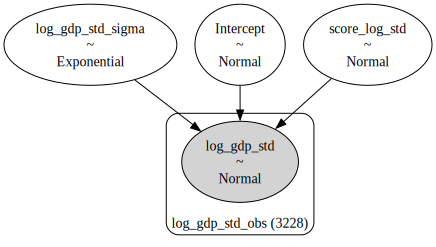

In [10]:
m_score.build()
m_score.graph()

Since this is a relatively simple model, we tune the sampler for 1000 timesteps and draw 1000 samples from the posterior:

In [11]:
fit_score = m_score.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ score_log_std"] = fit_score

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


A quick summary of the model wth ArViz indicates that globally, the cultural production score has small yet pronounced effect:

In [12]:
az.summary(models["gdp ~ score_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.958  0.002   0.953    0.962        0.0      0.0   
score_log_std      0.042  0.002   0.038    0.047        0.0      0.0   
log_gdp_std_sigma  0.052  0.001   0.050    0.053        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6759.0    3276.0    1.0  
score_log_std        6823.0    3129.0    1.0  
log_gdp_std_sigma    6349.0    3129.0    1.0

However, the model fit is not particularly good. To further examine this, we conduct a posterior predictive check where we plot the estimated posterior against the observed GDP distribution. Evidently, the model falls short in fitting the trimodal structure of the data:

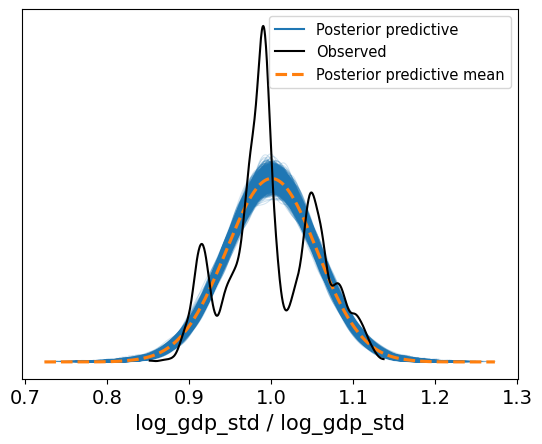

In [13]:
m_score.predict(fit_score, kind="pps")
az.plot_ppc(fit_score);

When we map the predictive posterior slopes against the empirical data in a scatter plot, it reaffirms our previous observation: the model is inadequate in accurately characterizing the data:

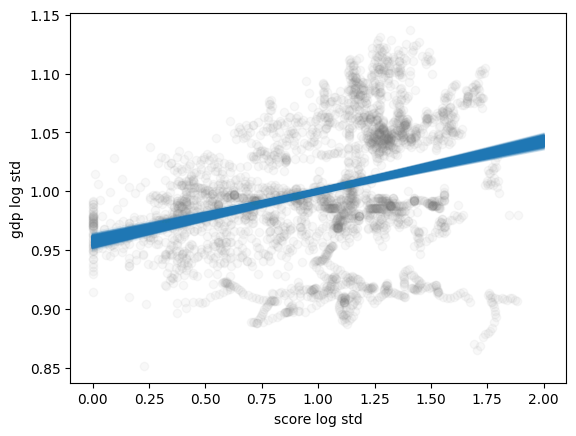

In [14]:
score_log_std_new = np.linspace(0, 2, num=200)
m_score.predict(fit_score, data=pd.DataFrame({"score_log_std": score_log_std_new}))
gdp = fit_score.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(score_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["score_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="score log std", ylabel="gdp log std");

We juxtapose this model with another where we employ the bias-corrected cultural production score as opposed to the unnormalized score. While the model specification remains consistent, its implementation unfolds as follows:

In [15]:
m_est = bmb.Model(
    f"log_gdp_std ~ N_est_log_std", df, family="gaussian", priors=priors)
fit_est = m_est.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ N_est_log_std"] = fit_est

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Similar to the previous analysis, a cursory analysis of the new model seems to suggest a slightly weaker but still positive correlation between the cultural production score and GDP:

In [16]:
az.summary(models["gdp ~ N_est_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.967  0.004   0.961    0.974        0.0      0.0   
N_est_log_std      0.033  0.003   0.026    0.039        0.0      0.0   
log_gdp_std_sigma  0.054  0.001   0.052    0.055        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6087.0    3003.0    1.0  
N_est_log_std        6086.0    3400.0    1.0  
log_gdp_std_sigma    6057.0    3206.0    1.0

This relationship is visualized in the following graph:

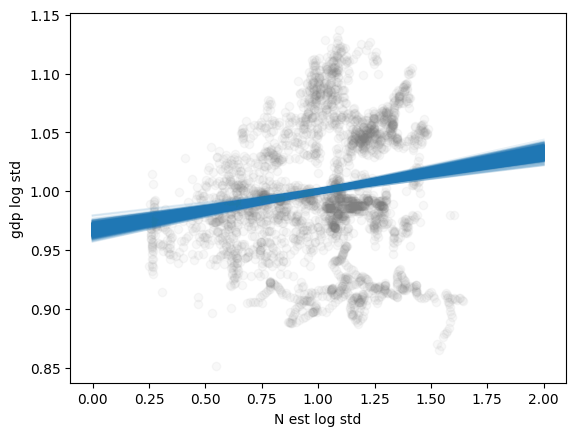

In [17]:
N_est_log_std_new = np.linspace(0, 2, num=200)
m_est.predict(fit_est, data=pd.DataFrame({"N_est_log_std": N_est_log_std_new}))
gdp = fit_est.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(N_est_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["N_est_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="N est log std", ylabel="gdp log std");

However, as indicated by the posterior predictive check, the model fit continues to disappointingly underperform:

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


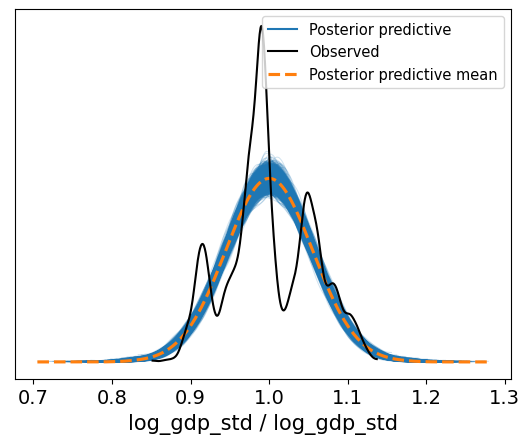

In [18]:
m_est.predict(fit_est, kind="pps")
az.plot_ppc(fit_est);

We utilize WAIC (Widely Applicable Information Criterion) or LOO to compare these models. This evaluation shows that the model incorporating the bias-corrected production variable does not perform better than one using the unnormalized variable. Nevertheless, as previously observed, both models exhibit subpar performance, suggesting caution in drawing any conclusions from this comparison. Overall, there appears evidence for a mildly positive relationship between the variables.

In [19]:
waic_compare = az.compare(models, ic='WAIC')
waic_compare

rank    elpd_waic    p_waic   elpd_diff  weight  \
gdp ~ score_log_std     0  4991.609929  2.826168    0.000000     1.0   
gdp ~ N_est_log_std     1  4862.239823  2.654430  129.370106     0.0   

                            se       dse  warning scale  
gdp ~ score_log_std  37.687803  0.000000    False   log  
gdp ~ N_est_log_std  35.913152  8.757268    False   log

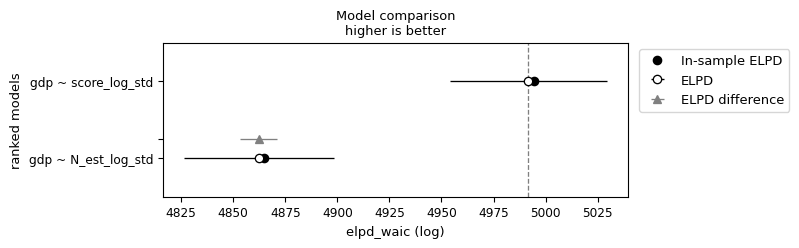

In [20]:
az.plot_compare(waic_compare, insample_dev=True);

## Hierarchical Linear Models

We now progress to a more nuanced analysis that leverages the inherent structure of our data, employing hierarchical linear models. Initially, we implement a rudimentary hierarchical model that only features varying intercepts for regions. This approach models each region as a distinct distribution, each contributing to the global intercept. The specification of the model is as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]}\\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In [21]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_vi = bmb.Model(
    "log_gdp_std ~ 1 + (1|region_name)", df, family="gaussian", noncentered=True, priors=priors)
m_vi

       Formula: log_gdp_std ~ 1 + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

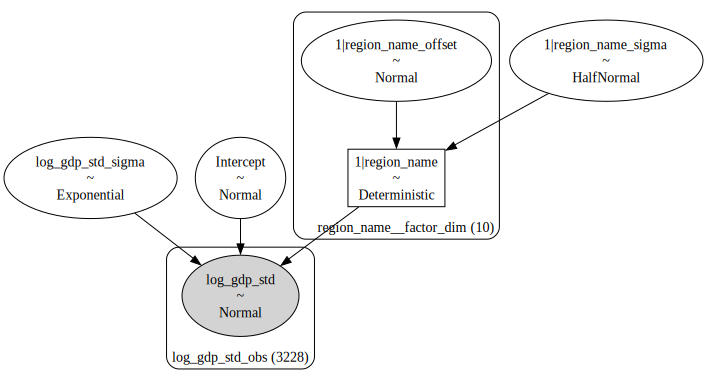

In [22]:
m_vi.build()
m_vi.graph()

The complexity of this model increases slightly, particularly due to the limited data points available for certain regions. Consequently, it's advisable to generate more posterior samples than in the previous models and proceed with a degree of caution while exploring the posterior during the sampling process:

In [23]:
m_vi_fit = m_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,  # more cautious exploration of the posterior
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ (1|region_name)"] = m_vi_fit
az.summary(m_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.981  0.019   0.944    1.018      0.001   
log_gdp_std_sigma                0.026  0.000   0.026    0.027      0.000   
1|region_name_sigma              0.058  0.017   0.033    0.090      0.000   
1|region_name[Chinese world]    -0.038  0.020  -0.076   -0.001      0.001   
1|region_name[Eastern Europe]   -0.067  0.019  -0.106   -0.032      0.001   
1|region_name[France]            0.008  0.019  -0.030    0.044      0.001   
1|region_name[German world]     -0.003  0.021  -0.043    0.037      0.001   
1|region_name[Italy]             0.072  0.019   0.034    0.108      0.001   
1|region_name[Japan]            -0.059  0.021  -0.098   -0.021      0.001   
1|region_name[Low countries]     0.083  0.019   0.043    0.118      0.001   
1|region_name[Nordic countries] -0.003  0.019  -0.043    0.031      0.001   
1|region_name[Spain]            -0.015  0.020  -0.055    0.020      0.001   
1|region_name[United Kingdom]    0.018  0.019  -0.020    0.054      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1397.0    1577.0    1.0  
log_gdp_std_sigma                    0.0    4486.0    3744.0    1.0  
1|region_name_sigma                  0.0    1457.0    1928.0    1.0  
1|region_name[Chinese world]         0.0    1435.0    1659.0    1.0  
1|region_name[Eastern Europe]        0.0    1406.0    1575.0    1.0  
1|region_name[France]                0.0    1395.0    1596.0    1.0  
1|region_name[German world]          0.0    1632.0    2028.0    1.0  
1|region_name[Italy]                 0.0    1399.0    1605.0    1.0  
1|region_name[Japan]                 0.0    1596.0    1836.0    1.0  
1|region_name[Low countries]         0.0    1400.0    1578.0    1.0  
1|region_name[Nordic countries]      0.0    1403.0    1589.0    1.0  
1|region_name[Spain]                 0.0    1426.0    1698.0    1.0  
1|region_name[United Kingdom]        0.0    1401.0    1609.0    1.0

The sampling process appears to be effective, characterized by $\hat{r}$ scores hovering around 1 and a satisfactory effective sample size. Below, we provide a forest plot for the varying intercepts. Bear in mind that due to the construction of the model (non-centered), these intercepts should be interpreted as deviations from the global mean intercept, which is not displayed here.

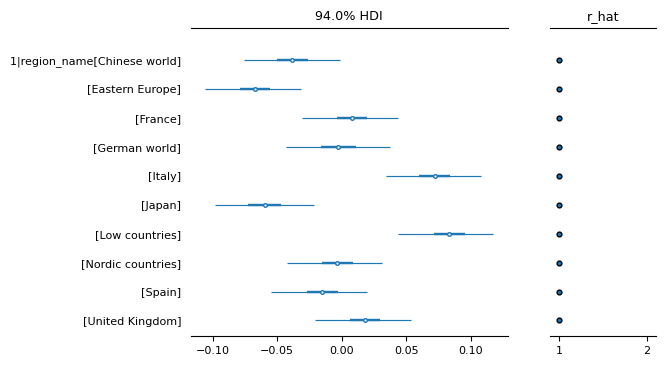

In [24]:
az.plot_forest(
    data=m_vi_fit, 
    figsize=(6, 4), 
    var_names=["1|region_name"], 
    r_hat=True, 
    combined=True, 
    textsize=8
);

Merely by incorporating the hierarchical levels associated with regions, we notice a significant improvement in the model fit, as illustrated in the subsequent posterior predictive check plot:

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


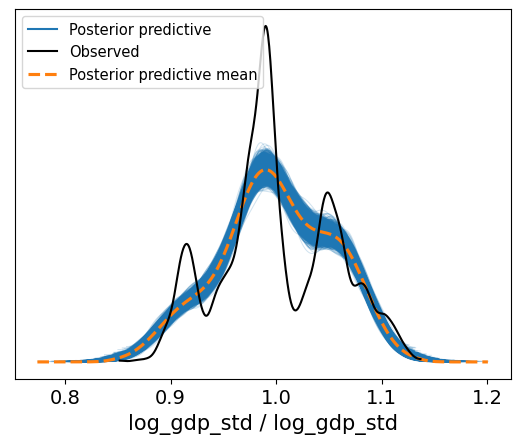

In [25]:
m_vi.predict(m_vi_fit, kind="pps")
az.plot_ppc(m_vi_fit);

### Varying Regions with Global Cultural Production Relationship

It thus seems that allowing variation in GDP per region is useful. We continue experimenting, adding the cultural production both regular and corrected to the model. The model description then becomes:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

Note that this is essentially the model proposed in the current version of the paper without the variable time. However, including time as a linear predictor will not change the most important lessons of the models below.

In [26]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_vi

       Formula: log_gdp_std ~ score_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

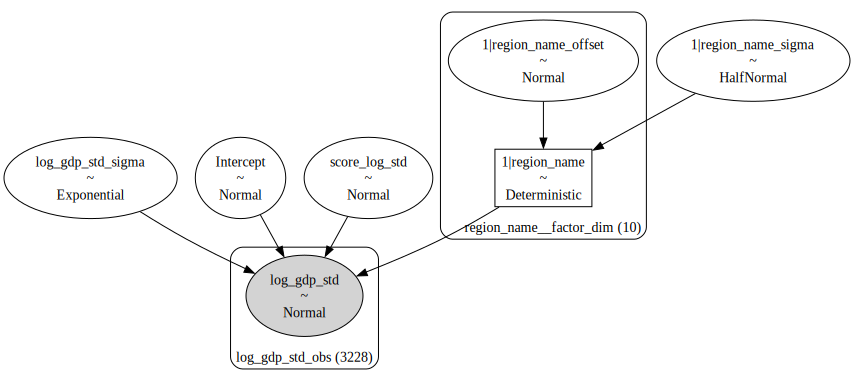

In [27]:
m_score_vi.build()
m_score_vi.graph()

In [28]:
m_score_vi_fit = m_score_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_log_std + (1|region_name)"] = m_score_vi_fit
az.summary(m_score_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 76 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.946  0.018   0.912    0.982        0.0   
score_log_std                    0.035  0.001   0.033    0.037        0.0   
log_gdp_std_sigma                0.023  0.000   0.022    0.024        0.0   
1|region_name_sigma              0.055  0.016   0.031    0.084        0.0   
1|region_name[Chinese world]    -0.027  0.019  -0.063    0.008        0.0   
1|region_name[Eastern Europe]   -0.071  0.018  -0.106   -0.036        0.0   
1|region_name[France]            0.007  0.018  -0.028    0.042        0.0   
1|region_name[German world]     -0.022  0.020  -0.060    0.015        0.0   
1|region_name[Italy]             0.065  0.018   0.030    0.100        0.0   
1|region_name[Japan]            -0.047  0.019  -0.085   -0.012        0.0   
1|region_name[Low countries]     0.082  0.018   0.048    0.117        0.0   
1|region_name[Nordic countries]  0.007  0.018  -0.028    0.042        0.0   
1|region_name[Spain]            -0.012  0.019  -0.047    0.024        0.0   
1|region_name[United Kingdom]    0.021  0.018  -0.013    0.057        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1466.0    1888.0    1.0  
score_log_std                        0.0    5595.0    4616.0    1.0  
log_gdp_std_sigma                    0.0    5978.0    4711.0    1.0  
1|region_name_sigma                  0.0    1884.0    2595.0    1.0  
1|region_name[Chinese world]         0.0    1491.0    1861.0    1.0  
1|region_name[Eastern Europe]        0.0    1466.0    1857.0    1.0  
1|region_name[France]                0.0    1462.0    1818.0    1.0  
1|region_name[German world]          0.0    1704.0    2126.0    1.0  
1|region_name[Italy]                 0.0    1462.0    1793.0    1.0  
1|region_name[Japan]                 0.0    1627.0    2205.0    1.0  
1|region_name[Low countries]         0.0    1467.0    1826.0    1.0  
1|region_name[Nordic countries]      0.0    1469.0    1823.0    1.0  
1|region_name[Spain]                 0.0    1484.0    1932.0    1.0  
1|region_name[United Kingdom]        0.0    1464.0    1837.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.035 CI [0.032, 0.037]). It seems that the model fit has experienced a slight enhancement

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


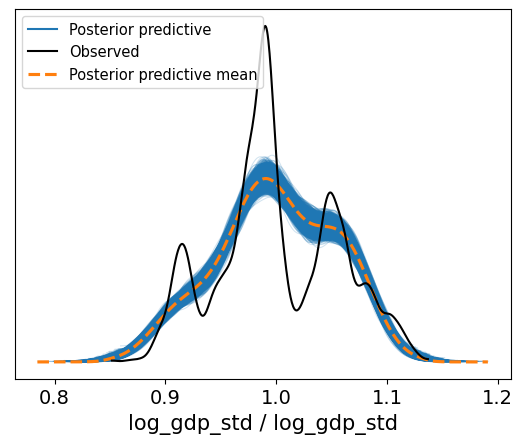

In [29]:
m_score_vi.predict(m_score_vi_fit, kind="pps")
az.plot_ppc(m_score_vi_fit);

Nevertheless, plotting the predictions against the observed data for each region provides more insightful information. This is depicted in the plot below, wherein it's evident that a global predictor of cultural production falls short in fitting the data accurately. Many regions, such as the Low Countries, the Chinese World, or Portugal, exhibit significant residuals, leaving a considerable amount of variation unexplained. Crucially, by assuming the relationship to be exclusively global, we imply it can only be unidirectional --- an assumption that, as we'll soon discover, may not necessarily hold true.

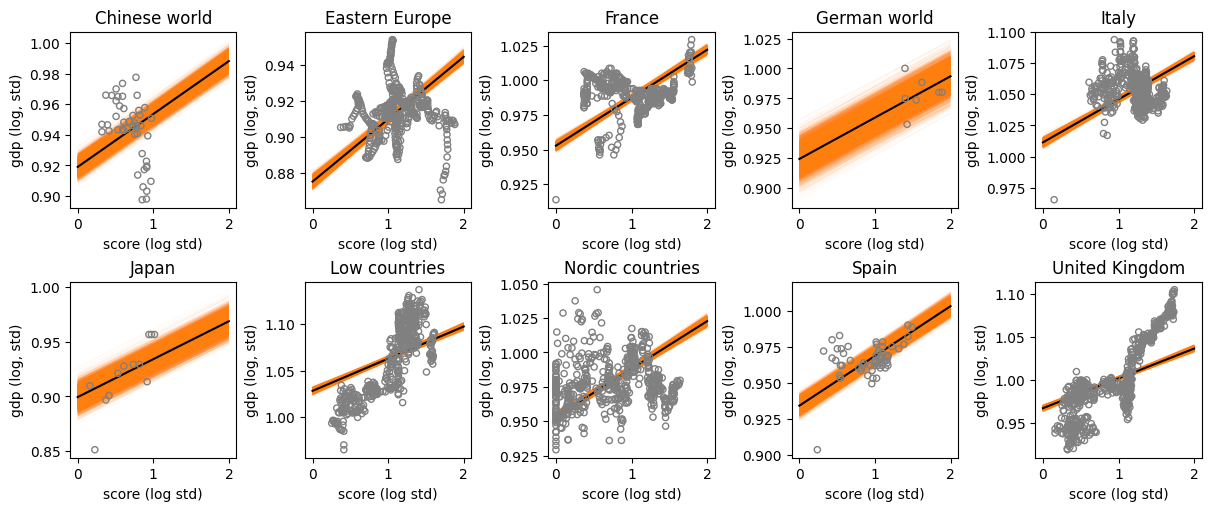

In [30]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

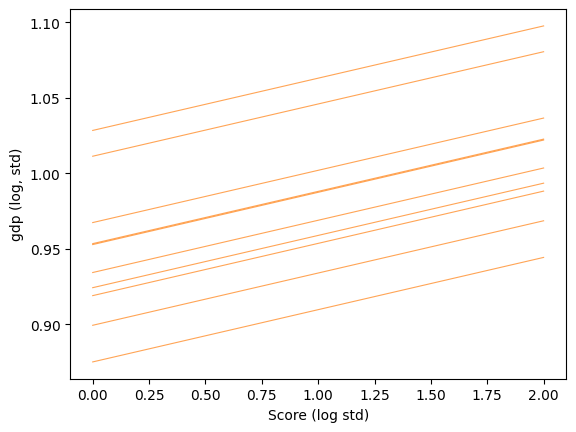

In [31]:
posterior = az.extract(m_score_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [32]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vi = bmb.Model(
    "log_gdp_std ~ N_est_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_vi

       Formula: log_gdp_std ~ N_est_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [33]:
m_est_vi_fit = m_est_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (1|region_name)"] = m_est_vi_fit
az.summary(m_est_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 73 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.936  0.019   0.900    0.971        0.0   
N_est_log_std                    0.044  0.002   0.041    0.047        0.0   
log_gdp_std_sigma                0.024  0.000   0.023    0.025        0.0   
1|region_name_sigma              0.058  0.017   0.033    0.089        0.0   
1|region_name[Chinese world]    -0.025  0.019  -0.060    0.012        0.0   
1|region_name[Eastern Europe]   -0.073  0.019  -0.106   -0.035        0.0   
1|region_name[France]            0.008  0.019  -0.025    0.046        0.0   
1|region_name[German world]     -0.021  0.020  -0.059    0.017        0.0   
1|region_name[Italy]             0.067  0.019   0.032    0.103        0.0   
1|region_name[Japan]            -0.048  0.020  -0.086   -0.012        0.0   
1|region_name[Low countries]     0.087  0.019   0.053    0.123        0.0   
1|region_name[Nordic countries]  0.005  0.019  -0.027    0.044        0.0   
1|region_name[Spain]            -0.012  0.019  -0.045    0.027        0.0   
1|region_name[United Kingdom]    0.022  0.019  -0.013    0.058        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1490.0    2000.0    1.0  
N_est_log_std                        0.0    5962.0    4929.0    1.0  
log_gdp_std_sigma                    0.0    5985.0    4618.0    1.0  
1|region_name_sigma                  0.0    1426.0    2344.0    1.0  
1|region_name[Chinese world]         0.0    1530.0    2098.0    1.0  
1|region_name[Eastern Europe]        0.0    1494.0    2140.0    1.0  
1|region_name[France]                0.0    1491.0    2029.0    1.0  
1|region_name[German world]          0.0    1726.0    2535.0    1.0  
1|region_name[Italy]                 0.0    1496.0    2187.0    1.0  
1|region_name[Japan]                 0.0    1653.0    2620.0    1.0  
1|region_name[Low countries]         0.0    1495.0    2163.0    1.0  
1|region_name[Nordic countries]      0.0    1490.0    2084.0    1.0  
1|region_name[Spain]                 0.0    1519.0    2115.0    1.0  
1|region_name[United Kingdom]        0.0    1498.0    2078.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

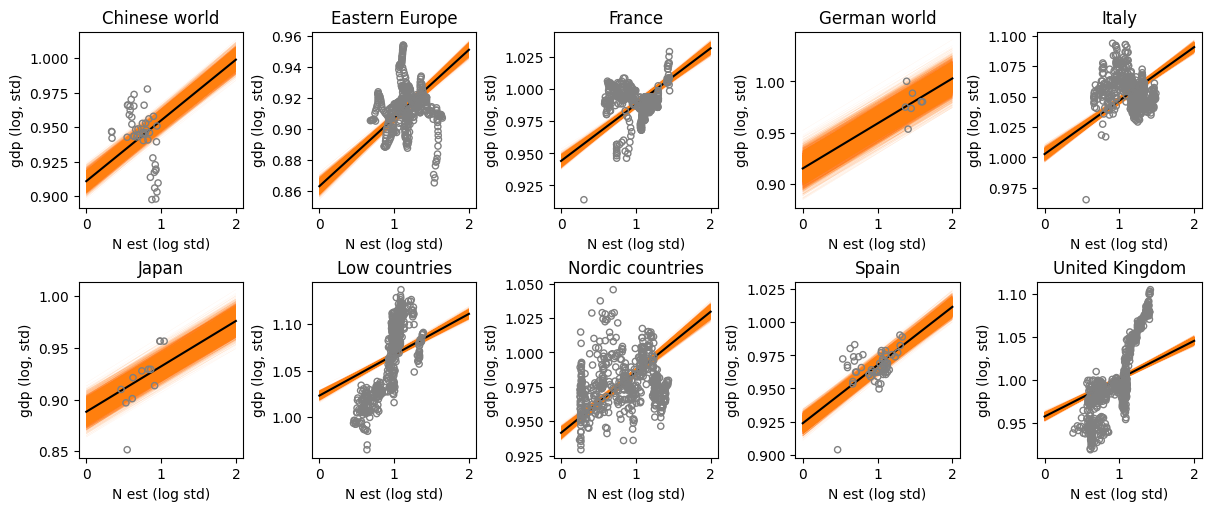

In [34]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est (log std)", title=region_name)

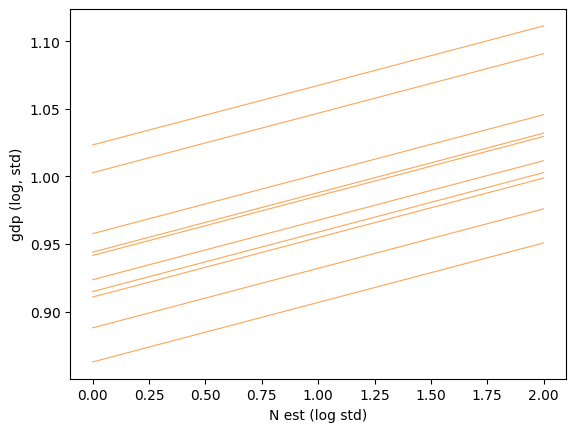

In [35]:
posterior = az.extract(m_est_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est (log std)");

#### Model comparison

We undertake a comparison of all models explored thus far, this time employing approximate leave-one-out cross-validation (LOO). The model incorporating varying intercepts on region and using cultural score as a global predictor appears to best fit the data. As expected, it is closely followed by the model utilizing bias-corrected cultural production scores. All models featuring varying intercepts significantly outperform those with a singular global intercept. The results are demonstrated in the subsequent table and accompanying figure.

In [36]:
waic_compare = az.compare(models, ic='LOO')

In [37]:
waic_compare

rank     elpd_loo      p_loo  \
log_gdp_std ~ score_log_std + (1|region_name)     0  7589.431944  11.423734   
log_gdp_std ~ N_est_log_std + (1|region_name)     1  7452.047034  11.127369   
log_gdp_std ~ (1|region_name)                     2  7146.391009  10.360764   
gdp ~ score_log_std                               3  4991.607004   2.829093   
gdp ~ N_est_log_std                               4  4862.236495   2.657758   

                                                 elpd_diff        weight  \
log_gdp_std ~ score_log_std + (1|region_name)     0.000000  9.816475e-01   
log_gdp_std ~ N_est_log_std + (1|region_name)   137.384911  6.989432e-08   
log_gdp_std ~ (1|region_name)                   443.040935  1.835244e-02   
gdp ~ score_log_std                            2597.824941  1.112687e-07   
gdp ~ N_est_log_std                            2727.195449  0.000000e+00   

                                                      se        dse  warning  \
log_gdp_std ~ score_log_std + (1|region_name)  41.154364   0.000000    False   
log_gdp_std ~ N_est_log_std + (1|region_name)  43.792820   8.407454    False   
log_gdp_std ~ (1|region_name)                  54.571205  30.137914    False   
gdp ~ score_log_std                            37.687891  50.161387    False   
gdp ~ N_est_log_std                            35.913236  48.131215    False   

                                              scale  
log_gdp_std ~ score_log_std + (1|region_name)   log  
log_gdp_std ~ N_est_log_std + (1|region_name)   log  
log_gdp_std ~ (1|region_name)                   log  
gdp ~ score_log_std                             log  
gdp ~ N_est_log_std                             log

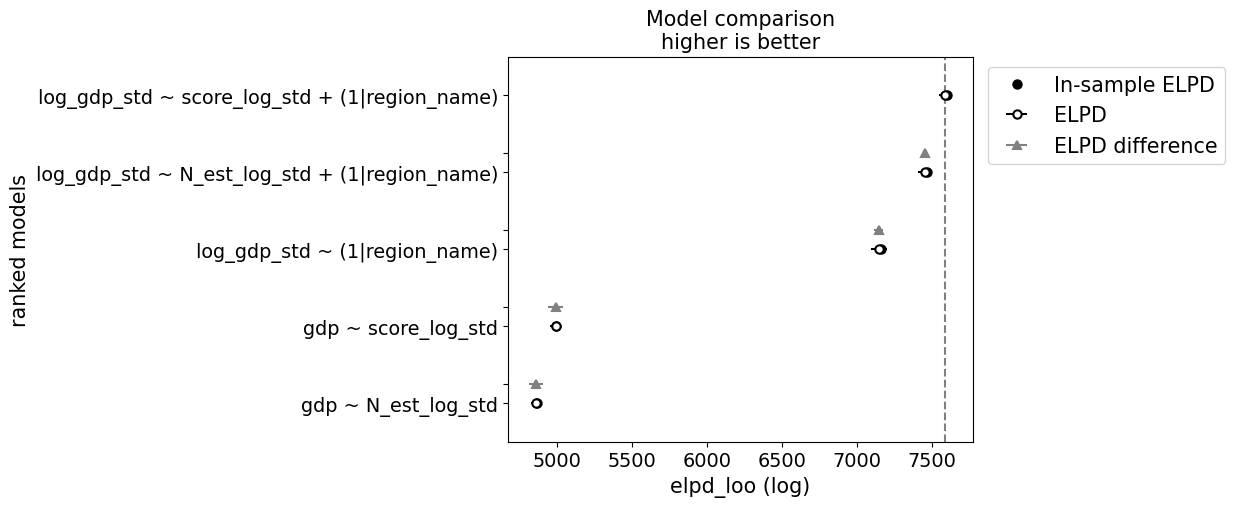

In [38]:
az.plot_compare(waic_compare, insample_dev=True);

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


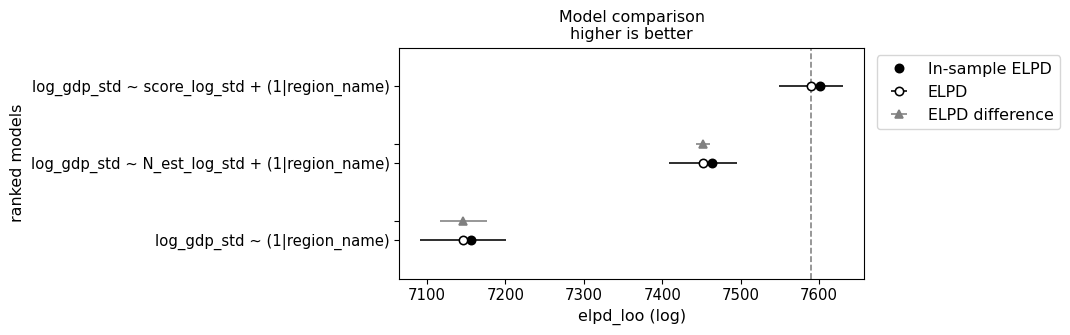

In [39]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("1|region_name")], insample_dev=True);

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [40]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)


The model graph looks as follows:

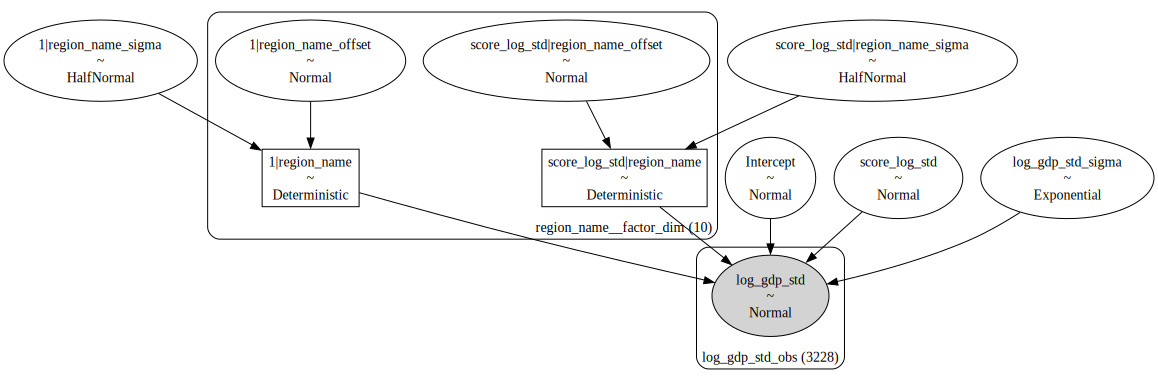

In [41]:
m_score_vs.build()
m_score_vs.graph()

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [42]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 269 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.960  0.020   0.922    0.998   
score_log_std                                0.022  0.018  -0.013    0.056   
log_gdp_std_sigma                            0.017  0.000   0.017    0.017   
1|region_name_sigma                          0.060  0.018   0.033    0.092   
score_log_std|region_name_sigma              0.055  0.016   0.030    0.086   
1|region_name[Chinese world]                 0.020  0.022  -0.022    0.061   
1|region_name[Eastern Europe]               -0.043  0.020  -0.081   -0.004   
1|region_name[France]                        0.025  0.020  -0.012    0.064   
1|region_name[German world]                 -0.001  0.038  -0.072    0.070   
1|region_name[Italy]                         0.103  0.021   0.065    0.142   
1|region_name[Japan]                        -0.084  0.023  -0.130   -0.044   
1|region_name[Low countries]                 0.006  0.020  -0.032    0.044   
1|region_name[Nordic countries]              0.014  0.020  -0.025    0.051   
1|region_name[Spain]                        -0.008  0.021  -0.049    0.031   
1|region_name[United Kingdom]               -0.037  0.020  -0.075    0.001   
score_log_std|region_name[Chinese world]    -0.075  0.022  -0.117   -0.036   
score_log_std|region_name[Eastern Europe]   -0.025  0.018  -0.058    0.012   
score_log_std|region_name[France]           -0.019  0.018  -0.052    0.016   
score_log_std|region_name[German world]     -0.010  0.027  -0.061    0.043   
score_log_std|region_name[Italy]            -0.030  0.018  -0.065    0.005   
score_log_std|region_name[Japan]             0.048  0.023   0.006    0.094   
score_log_std|region_name[Low countries]     0.072  0.018   0.040    0.110   
score_log_std|region_name[Nordic countries] -0.016  0.018  -0.050    0.019   
score_log_std|region_name[Spain]            -0.006  0.019  -0.042    0.031   
score_log_std|region_name[United Kingdom]    0.060  0.018   0.027    0.096   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.000      0.0    2621.0   
score_log_std                                    0.000      0.0    2180.0   
log_gdp_std_sigma                                0.000      0.0   10378.0   
1|region_name_sigma                              0.000      0.0    3015.0   
score_log_std|region_name_sigma                  0.000      0.0    2852.0   
1|region_name[Chinese world]                     0.000      0.0    3028.0   
1|region_name[Eastern Europe]                    0.000      0.0    2649.0   
1|region_name[France]                            0.000      0.0    2641.0   
1|region_name[German world]                      0.001      0.0    5312.0   
1|region_name[Italy]                             0.000      0.0    2716.0   
1|region_name[Japan]                             0.000      0.0    3117.0   
1|region_name[Low countries]                     0.000      0.0    2651.0   
1|region_name[Nordic countries]                  0.000      0.0    2625.0   
1|region_name[Spain]                             0.000      0.0    2930.0   
1|region_name[United Kingdom]                    0.000      0.0    2641.0   
score_log_std|region_name[Chinese world]         0.000      0.0    3042.0   
score_log_std|region_name[Eastern Europe]        0.000      0.0    2218.0   
score_log_std|region_name[France]                0.000      0.0    2205.0   
score_log_std|region_name[German world]          0.000      0.0    3627.0   
score_log_std|region_name[Italy]                 0.000      0.0    2209.0   
score_log_std|region_name[Japan]                 0.000      0.0    3228.0   
score_log_std|region_name[Low countries]         0.000      0.0    2186.0   
score_log_std|region_name[Nordic countries]      0.000      0.0    2180.0   
score_log_std|region_name[Spain]                 0.000      0.0    2420.0   
score_log_std|region_name[United Kingdom]        0.000      0.0    2205.0   

              

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

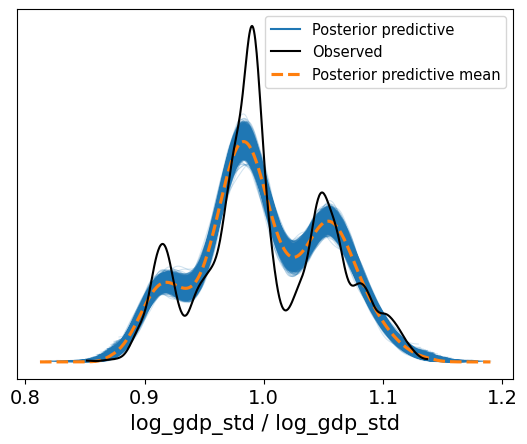

In [43]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

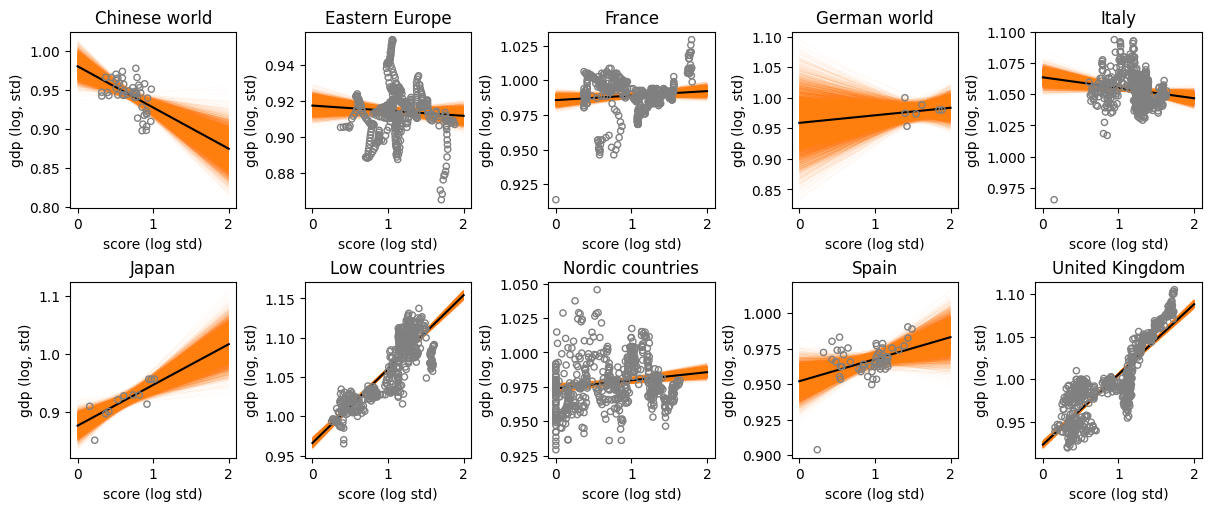

In [44]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

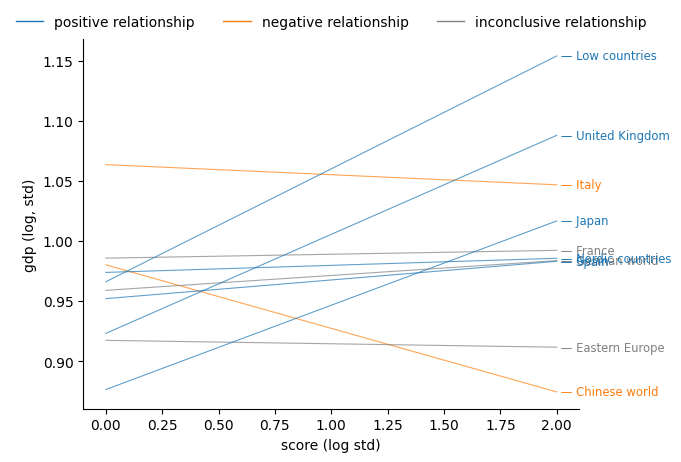

In [45]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

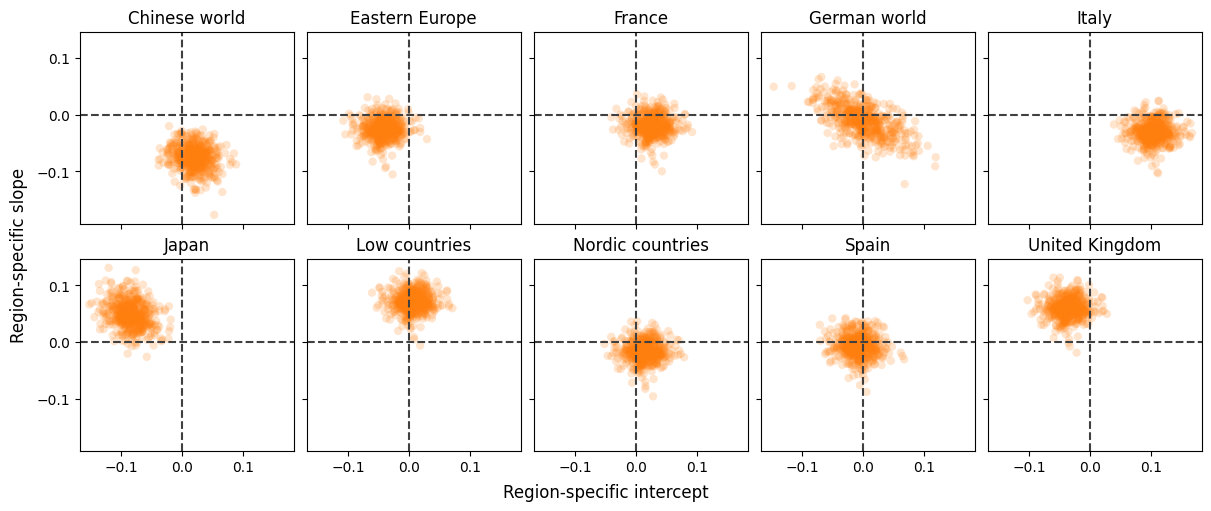

In [46]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [47]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

       Formula: log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [48]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit
az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 390 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.945  0.028   0.894    0.999   
N_est_log_std                                0.038  0.028  -0.014    0.093   
log_gdp_std_sigma                            0.018  0.000   0.017    0.018   
1|region_name_sigma                          0.079  0.024   0.042    0.121   
N_est_log_std|region_name_sigma              0.084  0.025   0.046    0.129   
1|region_name[Chinese world]                 0.042  0.029  -0.013    0.098   
1|region_name[Eastern Europe]               -0.028  0.028  -0.079    0.026   
1|region_name[France]                        0.039  0.028  -0.013    0.092   
1|region_name[German world]                 -0.000  0.059  -0.104    0.120   
1|region_name[Italy]                         0.124  0.028   0.071    0.177   
1|region_name[Japan]                        -0.100  0.033  -0.162   -0.040   
1|region_name[Low countries]                -0.022  0.028  -0.073    0.032   
1|region_name[Nordic countries]              0.025  0.028  -0.025    0.080   
1|region_name[Spain]                        -0.000  0.029  -0.053    0.057   
1|region_name[United Kingdom]               -0.079  0.028  -0.131   -0.026   
N_est_log_std|region_name[Chinese world]    -0.098  0.032  -0.160   -0.043   
N_est_log_std|region_name[Eastern Europe]   -0.041  0.029  -0.094    0.014   
N_est_log_std|region_name[France]           -0.033  0.029  -0.087    0.021   
N_est_log_std|region_name[German world]     -0.014  0.045  -0.108    0.064   
N_est_log_std|region_name[Italy]            -0.052  0.029  -0.108    0.001   
N_est_log_std|region_name[Japan]             0.063  0.036  -0.004    0.131   
N_est_log_std|region_name[Low countries]     0.113  0.029   0.058    0.166   
N_est_log_std|region_name[Nordic countries] -0.028  0.029  -0.082    0.027   
N_est_log_std|region_name[Spain]            -0.016  0.030  -0.073    0.041   
N_est_log_std|region_name[United Kingdom]    0.102  0.029   0.050    0.157   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.001    0.000    2481.0   
N_est_log_std                                    0.001    0.000    1927.0   
log_gdp_std_sigma                                0.000    0.000    9951.0   
1|region_name_sigma                              0.000    0.000    3129.0   
N_est_log_std|region_name_sigma                  0.000    0.000    2930.0   
1|region_name[Chinese world]                     0.001    0.000    2750.0   
1|region_name[Eastern Europe]                    0.001    0.000    2547.0   
1|region_name[France]                            0.001    0.000    2518.0   
1|region_name[German world]                      0.001    0.001    7141.0   
1|region_name[Italy]                             0.001    0.000    2543.0   
1|region_name[Japan]                             0.001    0.000    3299.0   
1|region_name[Low countries]                     0.001    0.000    2522.0   
1|region_name[Nordic countries]                  0.001    0.000    2485.0   
1|region_name[Spain]                             0.001    0.000    2672.0   
1|region_name[United Kingdom]                    0.001    0.000    2494.0   
N_est_log_std|region_name[Chinese world]         0.001    0.000    2316.0   
N_est_log_std|region_name[Eastern Europe]        0.001    0.000    1924.0   
N_est_log_std|region_name[France]                0.001    0.000    1938.0   
N_est_log_std|region_name[German world]          0.001    0.001    3877.0   
N_est_log_std|region_name[Italy]                 0.001    0.000    1917.0   
N_est_log_std|region_name[Japan]                 0.001    0.000    2894.0   
N_est_log_std|region_name[Low countries]         0.001    0.000    1968.0   
N_est_log_std|region_name[Nordic countries]      0.001    0.000    1928.0   
N_est_log_std|region_name[Spain]                 0.001    0.000    2109.0   
N_est_log_std|region_name[United Kingdom]        0.001    0.000    1922.0   

              

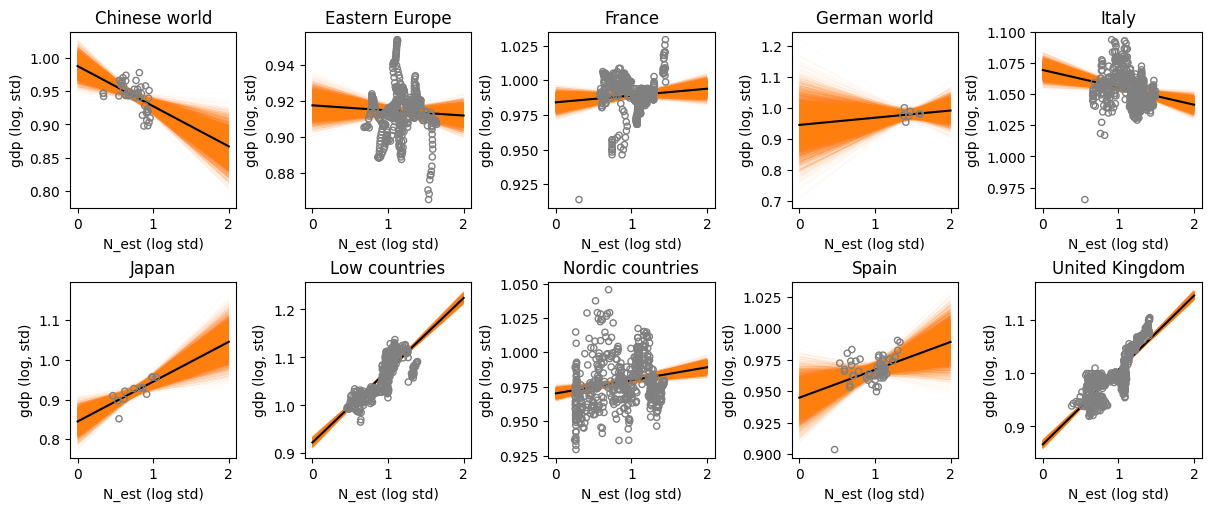

In [49]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

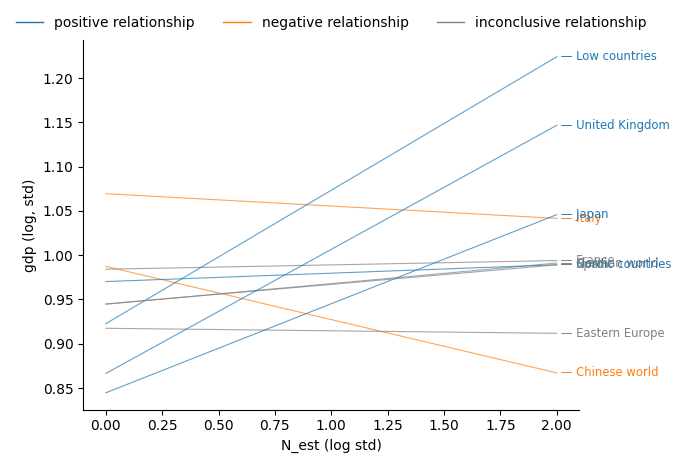

In [50]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [51]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

rank     elpd_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0  8554.564075   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  8412.912355   
log_gdp_std ~ score_log_std + (1|region_name)          2  7589.431944   
log_gdp_std ~ N_est_log_std + (1|region_name)          3  7452.047034   
log_gdp_std ~ (1|region_name)                          4  7146.391009   
gdp ~ score_log_std                                    5  4991.607004   
gdp ~ N_est_log_std                                    6  4862.236495   

                                                        p_loo    elpd_diff  \
log_gdp_std ~ score_log_std + (score_log_std|re...  22.387531     0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  21.751314   141.651720   
log_gdp_std ~ score_log_std + (1|region_name)       11.423734   965.132131   
log_gdp_std ~ N_est_log_std + (1|region_name)       11.127369  1102.517041   
log_gdp_std ~ (1|region_name)                       10.360764  1408.173065   
gdp ~ score_log_std                                  2.829093  3562.957071   
gdp ~ N_est_log_std                                  2.657758  3692.327580   

                                                          weight         se  \
log_gdp_std ~ score_log_std + (score_log_std|re...  9.531926e-01  49.104825   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  3.048396e-08  49.476245   
log_gdp_std ~ score_log_std + (1|region_name)       2.547282e-02  41.154364   
log_gdp_std ~ N_est_log_std + (1|region_name)       4.595658e-08  43.792820   
log_gdp_std ~ (1|region_name)                       2.133454e-02  54.571205   
gdp ~ score_log_std                                 5.364854e-08  37.687891   
gdp ~ N_est_log_std                                 0.000000e+00  35.913236   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000    False   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  12.100190    False   log  
log_gdp_std ~ score_log_std + (1|region_name)       46.317755    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)       49.611113    False   log  
log_gdp_std ~ (1|region_name)                       60.528178    False   log  
gdp ~ score_log_std                                 59.875075    False   log  
gdp ~ N_est_log_std                                 58.269089    False   log

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


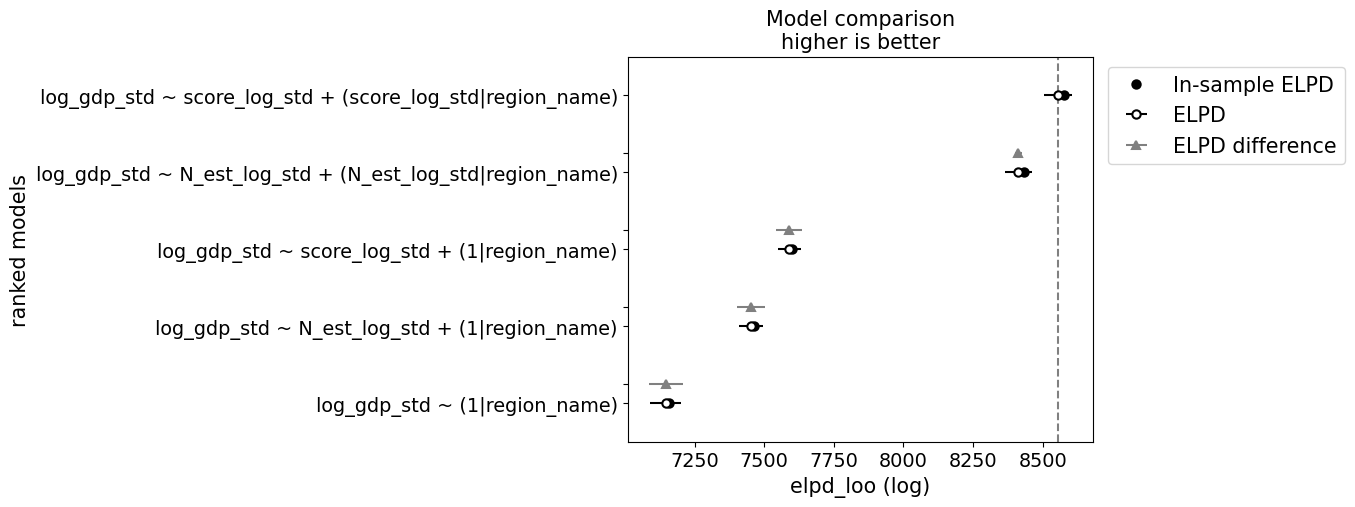

In [52]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

# Cultural score per capita

In the analsyses above, we correlated a global cultural production score (both corrected and uncorrected) with the GDP scores per capita. These scores ignore differences in population size. As a final step in the analysis, we repeat the analyses with varying intercepts and varying slopes, but swapping the unnormalized cultural production scores for the scores per capita. We begin with the uncorrected score:

In [53]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vi = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_cap_vi

       Formula: log_gdp_std ~ score_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

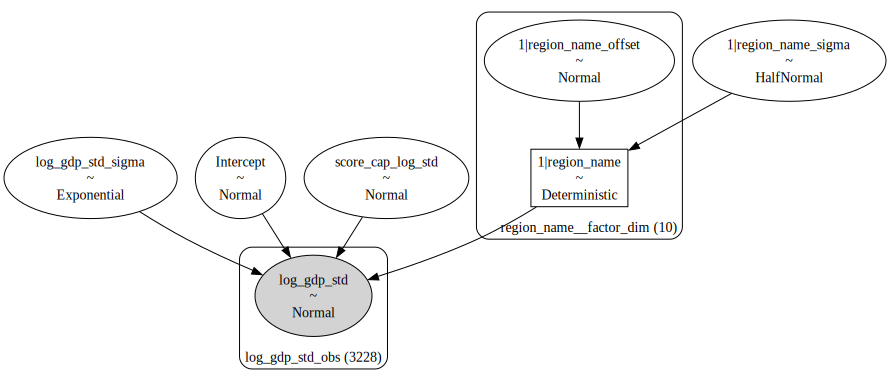

In [54]:
m_score_cap_vi.build()
m_score_cap_vi.graph()

In [55]:
m_score_cap_vi_fit = m_score_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_cap_log_std + (1|region_name)"] = m_score_cap_vi_fit
az.summary(m_score_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1683 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.963  0.017   0.933    0.996        0.0   
score_cap_log_std                0.023  0.001   0.022    0.025        0.0   
log_gdp_std_sigma                0.023  0.000   0.023    0.024        0.0   
1|region_name_sigma              0.050  0.015   0.027    0.076        0.0   
1|region_name[Chinese world]     0.000  0.017  -0.032    0.032        0.0   
1|region_name[Eastern Europe]   -0.069  0.017  -0.100   -0.038        0.0   
1|region_name[France]            0.010  0.017  -0.020    0.042        0.0   
1|region_name[German world]     -0.022  0.018  -0.057    0.012        0.0   
1|region_name[Italy]             0.063  0.017   0.032    0.095        0.0   
1|region_name[Japan]            -0.042  0.018  -0.075   -0.009        0.0   
1|region_name[Low countries]     0.068  0.017   0.036    0.099        0.0   
1|region_name[Nordic countries] -0.009  0.017  -0.041    0.022        0.0   
1|region_name[Spain]            -0.015  0.017  -0.049    0.014        0.0   
1|region_name[United Kingdom]    0.014  0.017  -0.019    0.044        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1403.0    2230.0    1.0  
score_cap_log_std                    0.0    5676.0    4646.0    1.0  
log_gdp_std_sigma                    0.0    5882.0    4749.0    1.0  
1|region_name_sigma                  0.0    1593.0    2521.0    1.0  
1|region_name[Chinese world]         0.0    1432.0    2190.0    1.0  
1|region_name[Eastern Europe]        0.0    1407.0    2235.0    1.0  
1|region_name[France]                0.0    1401.0    2243.0    1.0  
1|region_name[German world]          0.0    1663.0    2730.0    1.0  
1|region_name[Italy]                 0.0    1407.0    2275.0    1.0  
1|region_name[Japan]                 0.0    1595.0    2704.0    1.0  
1|region_name[Low countries]         0.0    1397.0    2245.0    1.0  
1|region_name[Nordic countries]      0.0    1408.0    2156.0    1.0  
1|region_name[Spain]                 0.0    1436.0    2312.0    1.0  
1|region_name[United Kingdom]        0.0    1396.0    2217.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.023 CI [0.022, 0.025]). It seems that the model fit is decent. 

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


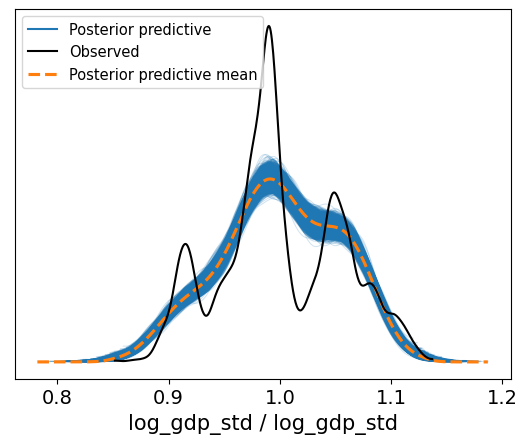

In [56]:
m_score_cap_vi.predict(m_score_cap_vi_fit, kind="pps")
az.plot_ppc(m_score_cap_vi_fit);

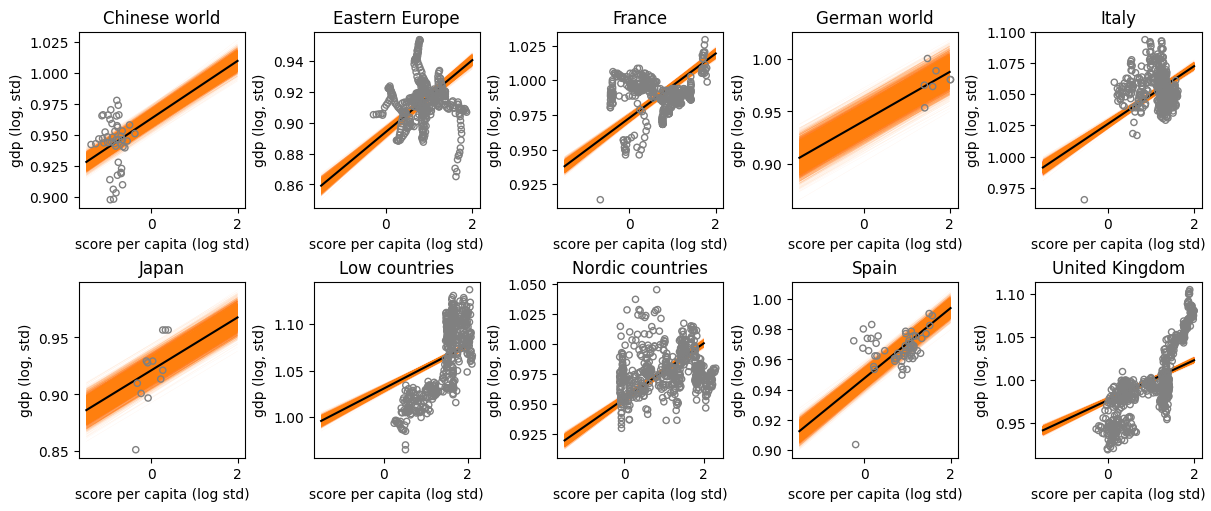

In [57]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

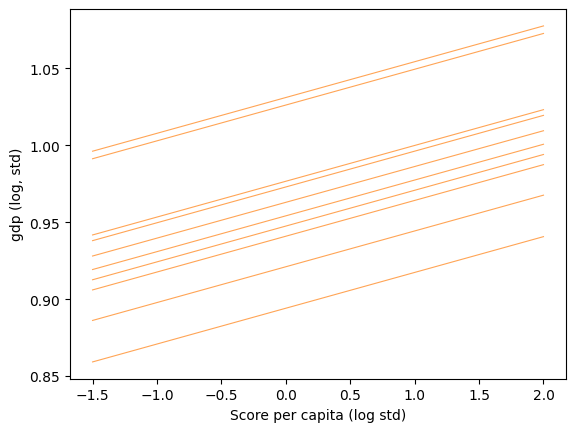

In [58]:
posterior = az.extract(m_score_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score per capita (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [59]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vi = bmb.Model(
    "log_gdp_std ~ N_est_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_cap_vi

       Formula: log_gdp_std ~ N_est_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [60]:
m_est_cap_vi_fit = m_est_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (1|region_name)"] = m_est_cap_vi_fit
az.summary(m_est_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.948  0.018   0.915    0.981        0.0   
N_est_cap_log_std                0.036  0.002   0.033    0.038        0.0   
log_gdp_std_sigma                0.024  0.000   0.024    0.025        0.0   
1|region_name_sigma              0.054  0.017   0.030    0.083        0.0   
1|region_name[Chinese world]    -0.004  0.018  -0.038    0.030        0.0   
1|region_name[Eastern Europe]   -0.072  0.018  -0.104   -0.038        0.0   
1|region_name[France]            0.011  0.018  -0.022    0.044        0.0   
1|region_name[German world]     -0.021  0.020  -0.055    0.017        0.0   
1|region_name[Italy]             0.066  0.018   0.032    0.098        0.0   
1|region_name[Japan]            -0.045  0.019  -0.079   -0.009        0.0   
1|region_name[Low countries]     0.077  0.018   0.046    0.111        0.0   
1|region_name[Nordic countries] -0.007  0.018  -0.039    0.026        0.0   
1|region_name[Spain]            -0.015  0.018  -0.049    0.018        0.0   
1|region_name[United Kingdom]    0.016  0.018  -0.017    0.049        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1534.0    2043.0    1.0  
N_est_cap_log_std                    0.0    5393.0    3798.0    1.0  
log_gdp_std_sigma                    0.0    5487.0    4538.0    1.0  
1|region_name_sigma                  0.0    1550.0    2207.0    1.0  
1|region_name[Chinese world]         0.0    1590.0    2105.0    1.0  
1|region_name[Eastern Europe]        0.0    1534.0    1994.0    1.0  
1|region_name[France]                0.0    1532.0    2065.0    1.0  
1|region_name[German world]          0.0    1795.0    2412.0    1.0  
1|region_name[Italy]                 0.0    1536.0    1988.0    1.0  
1|region_name[Japan]                 0.0    1692.0    2421.0    1.0  
1|region_name[Low countries]         0.0    1537.0    2038.0    1.0  
1|region_name[Nordic countries]      0.0    1536.0    2022.0    1.0  
1|region_name[Spain]                 0.0    1566.0    2150.0    1.0  
1|region_name[United Kingdom]        0.0    1538.0    2040.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

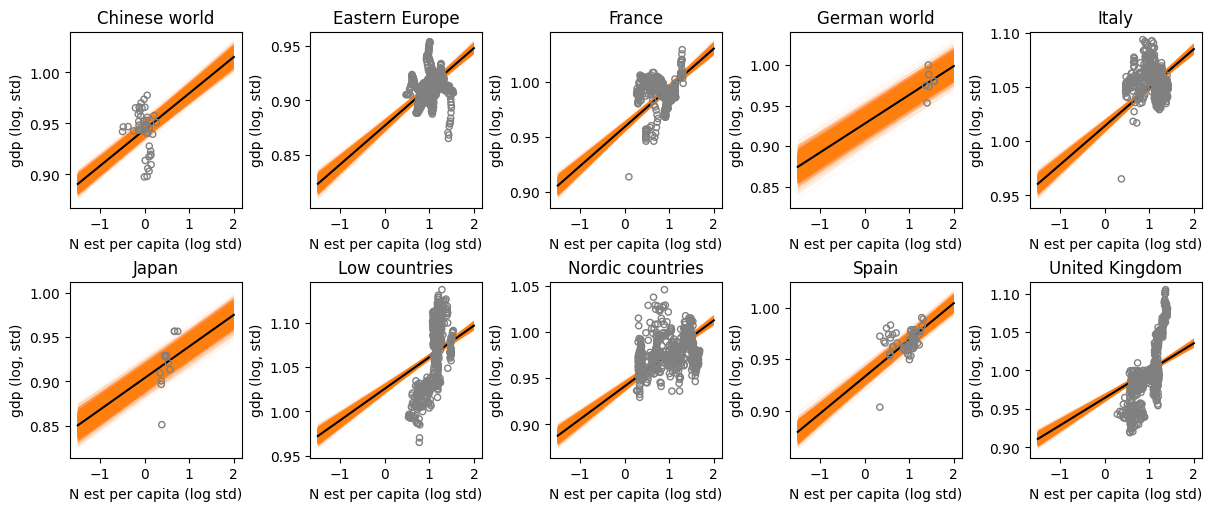

In [61]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est per capita (log std)", title=region_name)

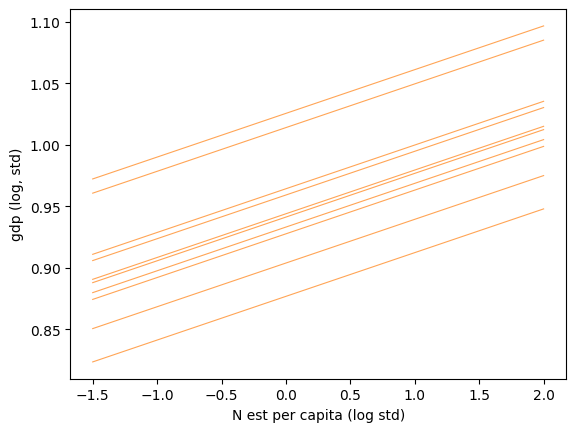

In [62]:
posterior = az.extract(m_est_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est per capita (log std)");

### Varying Slopes for Cultural Production in Different Regions

In [63]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vs = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_cap_vs

       Formula: log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

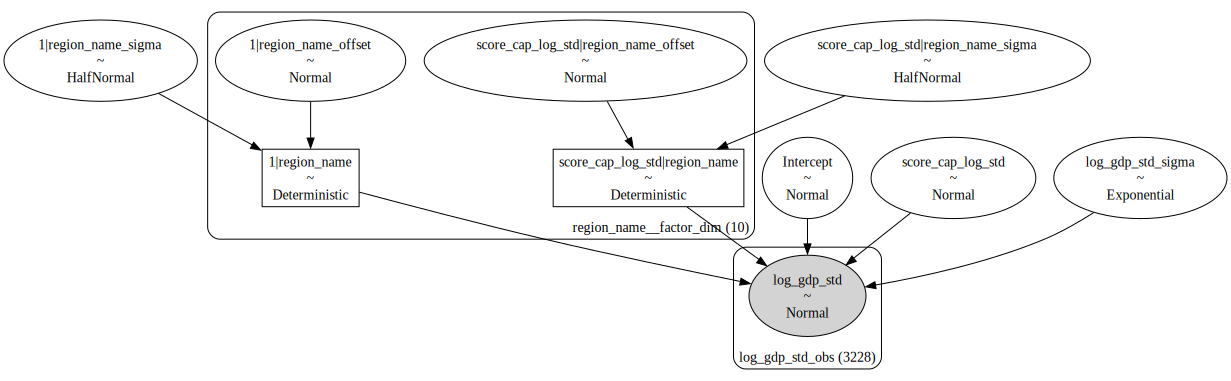

In [64]:
m_score_cap_vs.build()
m_score_cap_vs.graph()

In [65]:
m_score_cap_vs_fit = m_score_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)"] = m_score_cap_vs_fit
az.summary(m_score_cap_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset, score_cap_log_std|region_name_sigma, score_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 218 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        0.962  0.016   0.932   
score_cap_log_std                                0.022  0.012  -0.002   
log_gdp_std_sigma                                0.018  0.000   0.017   
1|region_name_sigma                              0.049  0.014   0.027   
score_cap_log_std|region_name_sigma              0.037  0.011   0.018   
1|region_name[Chinese world]                    -0.022  0.019  -0.059   
1|region_name[Eastern Europe]                   -0.047  0.016  -0.078   
1|region_name[France]                            0.025  0.016  -0.005   
1|region_name[German world]                     -0.006  0.031  -0.062   
1|region_name[Italy]                             0.094  0.017   0.062   
1|region_name[Japan]                            -0.043  0.017  -0.076   
1|region_name[Low countries]                     0.006  0.016  -0.026   
1|region_name[Nordic countries]                  0.011  0.016  -0.020   
1|region_name[Spain]                            -0.003  0.017  -0.036   
1|region_name[United Kingdom]                   -0.018  0.016  -0.047   
score_cap_log_std|region_name[Chinese world]    -0.025  0.017  -0.056   
score_cap_log_std|region_name[Eastern Europe]   -0.023  0.013  -0.048   
score_cap_log_std|region_name[France]           -0.019  0.012  -0.044   
score_cap_log_std|region_name[German world]     -0.008  0.020  -0.046   
score_cap_log_std|region_name[Italy]            -0.024  0.013  -0.047   
score_cap_log_std|region_name[Japan]             0.049  0.021   0.010   
score_cap_log_std|region_name[Low countries]     0.045  0.012   0.021   
score_cap_log_std|region_name[Nordic countries] -0.017  0.012  -0.041   
score_cap_log_std|region_name[Spain]            -0.013  0.013  -0.038   
score_cap_log_std|region_name[United Kingdom]    0.034  0.012   0.011   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          0.993        0.0      0.0   
score_cap_log_std                                  0.046        0.0      0.0   
log_gdp_std_sigma                                  0.018        0.0      0.0   
1|region_name_sigma                                0.074        0.0      0.0   
score_cap_log_std|region_name_sigma                0.056        0.0      0.0   
1|region_name[Chinese world]                       0.013        0.0      0.0   
1|region_name[Eastern Europe]                     -0.016        0.0      0.0   
1|region_name[France]                              0.057        0.0      0.0   
1|region_name[German world]                        0.055        0.0      0.0   
1|region_name[Italy]                               0.125        0.0      0.0   
1|region_name[Japan]                              -0.013        0.0      0.0   
1|region_name[Low countries]                       0.036        0.0      0.0   
1|region_name[Nordic countries]                    0.042        0.0      0.0   
1|region_name[Spain]                               0.028        0.0      0.0   
1|region_name[United Kingdom]                      0.014        0.0      0.0   
score_cap_log_std|region_name[Chinese world]       0.006        0.0      0.0   
score_cap_log_std|region_name[Eastern Europe]     -0.000        0.0      0.0   
score_cap_log_std|region_name[France]              0.003        0.0      0.0   
score_cap_log_std|region_name[German world]        0.029        0.0      0.0   
score_cap_log_std|region_name[Italy]               0.000        0.0      0.0   
score_cap_log_std|region_name[Japan]               0.090        0.0      0.0   
score_cap_log_std|region_name[Low countries]       0.069        0.0      0.0   
score_cap_log_std|region_name[Nordic countries]    0.006        0.0      0.0   
score_cap_log_std|region_name[Spain]               0.012        0.0      0.0   
score_cap_log_std|region_name[United Kingdom]      0.058        0.0      0.0   

                                                 ess_bulk  ess_tail  r

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


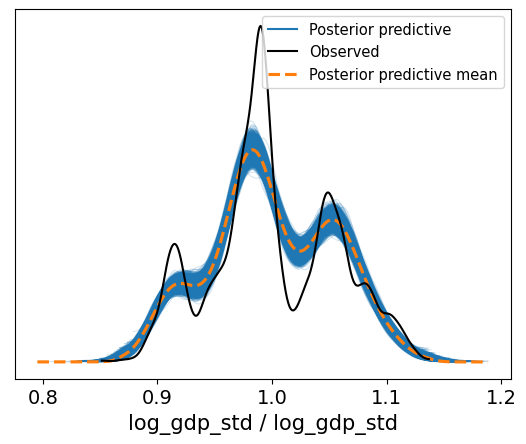

In [66]:
m_score_cap_vs.predict(m_score_cap_vs_fit, kind="pps")
az.plot_ppc(m_score_cap_vs_fit);

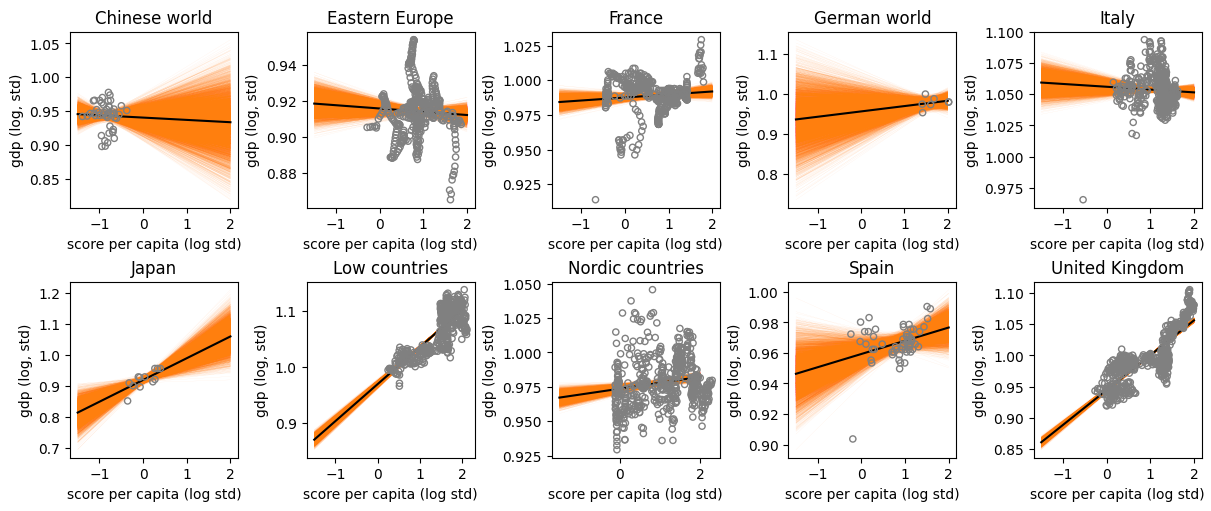

In [67]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

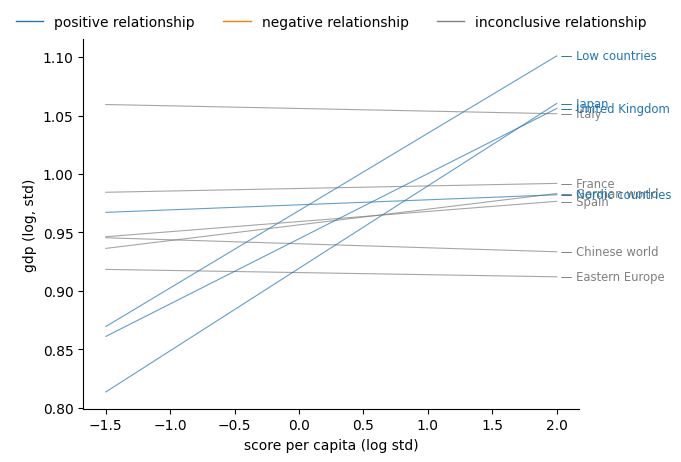

In [68]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score per capita (log std)");

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [69]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vs = bmb.Model(
    "log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_cap_vs

       Formula: log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [70]:
m_est_cap_vs_fit = m_est_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (N_est_cap_log_std|region_name)"] = m_est_cap_vs_fit
az.summary(m_est_cap_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_cap_log_std|region_name_sigma, N_est_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 384 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        0.940  0.024   0.890   
N_est_cap_log_std                                0.041  0.026  -0.008   
log_gdp_std_sigma                                0.019  0.000   0.018   
1|region_name_sigma                              0.071  0.023   0.037   
N_est_cap_log_std|region_name_sigma              0.076  0.023   0.042   
1|region_name[Chinese world]                     0.002  0.025  -0.045   
1|region_name[Eastern Europe]                   -0.024  0.025  -0.071   
1|region_name[France]                            0.045  0.025  -0.002   
1|region_name[German world]                     -0.008  0.056  -0.118   
1|region_name[Italy]                             0.124  0.025   0.079   
1|region_name[Japan]                            -0.083  0.030  -0.140   
1|region_name[Low countries]                    -0.028  0.025  -0.074   
1|region_name[Nordic countries]                  0.029  0.025  -0.017   
1|region_name[Spain]                             0.011  0.026  -0.037   
1|region_name[United Kingdom]                   -0.061  0.025  -0.105   
N_est_cap_log_std|region_name[Chinese world]    -0.073  0.031  -0.130   
N_est_cap_log_std|region_name[Eastern Europe]   -0.042  0.026  -0.091   
N_est_cap_log_std|region_name[France]           -0.036  0.026  -0.086   
N_est_cap_log_std|region_name[German world]     -0.009  0.043  -0.091   
N_est_cap_log_std|region_name[Italy]            -0.050  0.026  -0.100   
N_est_cap_log_std|region_name[Japan]             0.086  0.043   0.006   
N_est_cap_log_std|region_name[Low countries]     0.098  0.026   0.046   
N_est_cap_log_std|region_name[Nordic countries] -0.032  0.026  -0.082   
N_est_cap_log_std|region_name[Spain]            -0.025  0.027  -0.078   
N_est_cap_log_std|region_name[United Kingdom]    0.081  0.026   0.030   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          0.984      0.000    0.000   
N_est_cap_log_std                                  0.090      0.001    0.000   
log_gdp_std_sigma                                  0.019      0.000    0.000   
1|region_name_sigma                                0.112      0.000    0.000   
N_est_cap_log_std|region_name_sigma                0.118      0.000    0.000   
1|region_name[Chinese world]                       0.049      0.000    0.000   
1|region_name[Eastern Europe]                      0.025      0.000    0.000   
1|region_name[France]                              0.092      0.000    0.000   
1|region_name[German world]                        0.095      0.001    0.001   
1|region_name[Italy]                               0.173      0.000    0.000   
1|region_name[Japan]                              -0.026      0.001    0.000   
1|region_name[Low countries]                       0.020      0.000    0.000   
1|region_name[Nordic countries]                    0.077      0.000    0.000   
1|region_name[Spain]                               0.061      0.000    0.000   
1|region_name[United Kingdom]                     -0.010      0.000    0.000   
N_est_cap_log_std|region_name[Chinese world]      -0.015      0.001    0.000   
N_est_cap_log_std|region_name[Eastern Europe]      0.008      0.001    0.000   
N_est_cap_log_std|region_name[France]              0.013      0.001    0.000   
N_est_cap_log_std|region_name[German world]        0.072      0.001    0.000   
N_est_cap_log_std|region_name[Italy]              -0.001      0.001    0.000   
N_est_cap_log_std|region_name[Japan]               0.167      0.001    0.000   
N_est_cap_log_std|region_name[Low countries]       0.146      0.001    0.000   
N_est_cap_log_std|region_name[Nordic countries]    0.017      0.001    0.000   
N_est_cap_log_std|region_name[Spain]               0.026      0.001    0.000   
N_est_cap_log_std|region_name[United Kingdom]      0.129      0.001    0.000   

                                                 ess_bulk  ess_tail  r

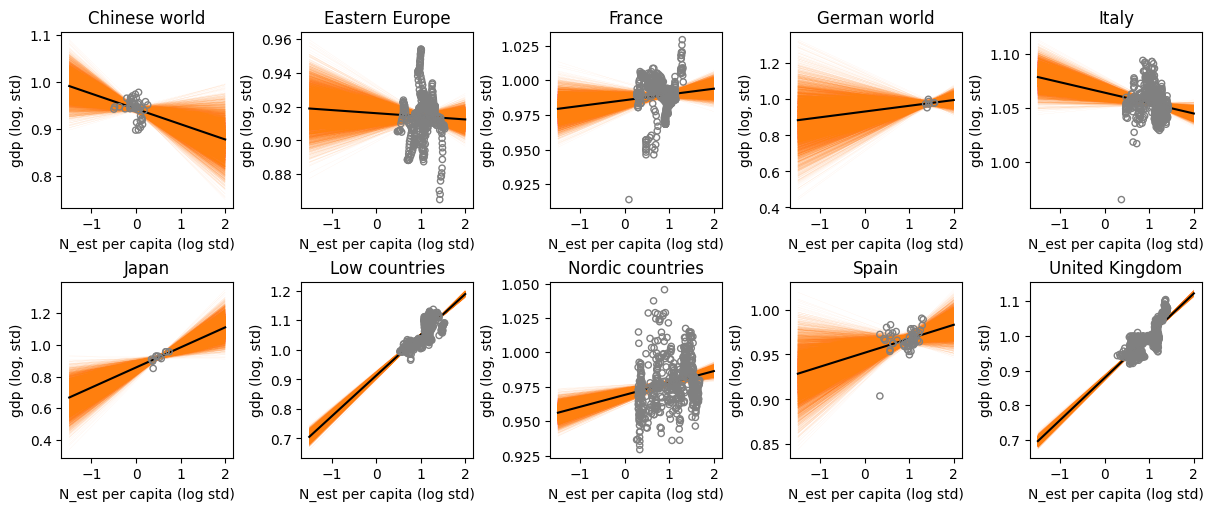

In [71]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)", title=region_name)

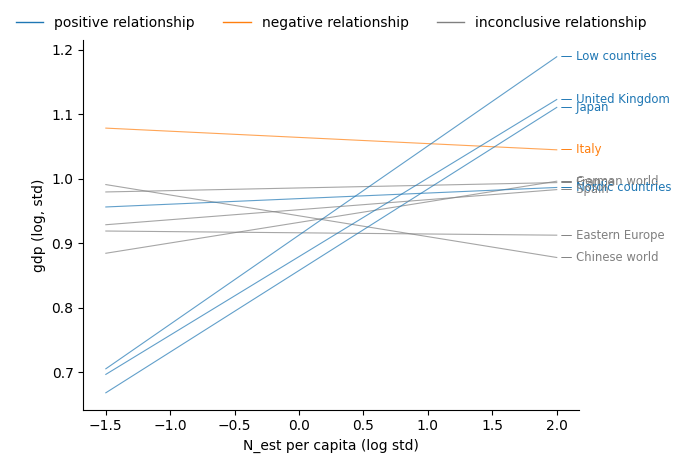

In [72]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models. Furthermore, we note that the bias-correction does not improve the model fit considerably. Finally, representing the cultural scores per capita does not improve the model fit either. 

In [73]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

rank     elpd_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0  8554.564075   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  8412.912355   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     2  8397.698064   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...     3  8216.236838   
log_gdp_std ~ score_log_std + (1|region_name)          4  7589.431944   
log_gdp_std ~ score_cap_log_std + (1|region_name)      5  7556.052245   
log_gdp_std ~ N_est_log_std + (1|region_name)          6  7452.047034   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)      7  7398.804980   
log_gdp_std ~ (1|region_name)                          8  7146.391009   
gdp ~ score_log_std                                    9  4991.607004   
gdp ~ N_est_log_std                                   10  4862.236495   

                                                        p_loo    elpd_diff  \
log_gdp_std ~ score_log_std + (score_log_std|re...  22.387531     0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  21.751314   141.651720   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  21.069098   156.866011   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  19.581524   338.327237   
log_gdp_std ~ score_log_std + (1|region_name)       11.423734   965.132131   
log_gdp_std ~ score_cap_log_std + (1|region_name)   11.392781   998.511830   
log_gdp_std ~ N_est_log_std + (1|region_name)       11.127369  1102.517041   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   11.077156  1155.759095   
log_gdp_std ~ (1|region_name)                       10.360764  1408.173065   
gdp ~ score_log_std                                  2.829093  3562.957071   
gdp ~ N_est_log_std                                  2.657758  3692.327580   

                                                          weight         se  \
log_gdp_std ~ score_log_std + (score_log_std|re...  9.535902e-01  49.104825   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  8.917180e-10  49.476245   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  9.915219e-10  47.772318   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  2.075490e-09  47.678350   
log_gdp_std ~ score_log_std + (1|region_name)       1.439036e-02  41.154364   
log_gdp_std ~ score_cap_log_std + (1|region_name)   1.073583e-02  42.608875   
log_gdp_std ~ N_est_log_std + (1|region_name)       2.887705e-09  43.792820   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   2.497591e-10  45.875143   
log_gdp_std ~ (1|region_name)                       2.128356e-02  54.571205   
gdp ~ score_log_std                                 0.000000e+00  37.687891   
gdp ~ N_est_log_std                                 8.254230e-10  35.913236   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000    False   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  12.100190    False   log  
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  14.396050    False   log  
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  18.198840    False   log  
log_gdp_std ~ score_log_std + (1|region_name)       46.317755    False   log  
log_gdp_std ~ score_cap_log_std + (1|region_name)   47.529561    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)       49.611113    False   log  
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   51.550610    False   log  
log_gdp_std ~ (1|region_name)                       60.528178    False   log  
gdp ~ score_log_std                                 59.875075    False   log  
gdp ~ N_est_log_std                                 58.269089    False   log

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


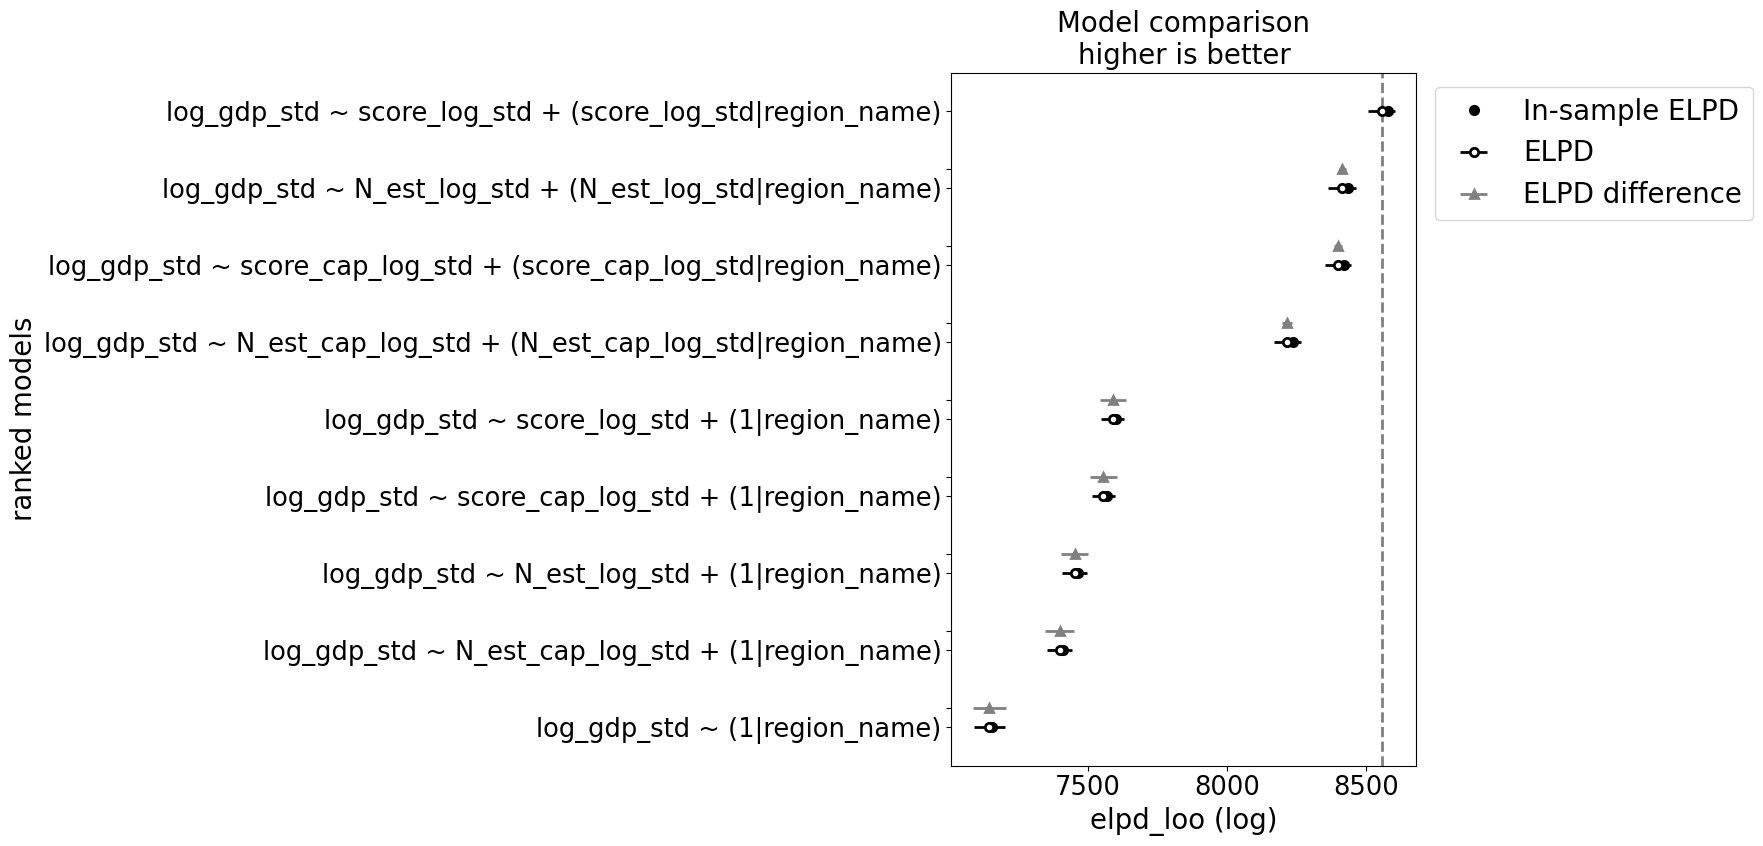

In [74]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

In [75]:
priors

{'Intercept': Normal(mu: 1.0, sigma: 1.0),
 'common': Normal(mu: 0.0, sigma: 1.0),
 '1|region_name': Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0)),
 'N_est_cap_log_std|region_name': Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0)),
 'sigma': Exponential(lam: 1.0)}

## Top 50% Global

In [98]:
df_top_50 = pd.read_csv("data/data_stats_filtered_top_50.csv", index_col=0)
df_top_50["region_name_id"] = pd.factorize(df_top_50["region_name"])[0]
print(f"N = {df_top_50.shape[0]}")
df_top_50.sample(5)

N = 3228


year     region_name  population_interpolated         N_est  \
827   1637          France                    20.35   2850.223772   
528   1338          France                    14.10     53.646579   
1950  1746   Low countries                     4.21   1273.483553   
664   1474          France                    13.96    479.151609   
433   1795  Eastern Europe                    28.45  22985.908493   

             lower         upper  score  score_cap   lower_cap   N_est_cap  \
827    2643.003584   3068.002987  201.3   9.870366  129.615293  139.780489   
528      43.025719     65.042948    2.4   0.169458    3.048421    3.800769   
1950   1175.647922   1375.388794  113.0  26.864918  279.279734  302.521594   
664     414.999150    548.821519   28.2   2.006736   29.517491   34.081315   
433   21448.016454  24564.871968  548.5  19.125052  748.460757  802.191096   

       upper_cap  gdp_per_capita  inclusive  restricted  region_name_id  
827   150.463056            1659          1           1               2  
528     4.608024            1710          1           1               2  
1950  326.733194            3977          1           1               6  
664    39.037707            1761          1           1               2  
433   857.365841             940          1           1               1

[MODIFICATION CHARLES] no.log(1+x) en raison des valeurs négatives

In [126]:
# Apply normalization
df_top_50["century"] = df_top_50["year"].round(-2)

df_top_50["score_log"] = np.log(1 + df_top_50["score"])
df_top_50["score_cap_log"] = np.log(1 + df_top_50["score_cap"])

df_top_50["N_est_log"] = np.log(1 + df_top_50["N_est"])
df_top_50["N_est_cap_log"] = np.log(1 + df_top_50["N_est_cap"])

df_top_50["score_log_std"] = df_top_50["score_log"] / df_top_50["score_log"].mean()
df_top_50["score_cap_log_std"] = np.log(df_top_50["score_cap_log"]) / df_top_50["score_cap_log"].mean()

df_top_50["N_est_log_std"] = df_top_50["N_est_log"] / df_top_50["N_est_log"].mean()
df_top_50["N_est_cap_log_std"] = np.log(df_top_50["N_est_cap"]) / df_top_50["N_est_cap_log"].mean()

df_top_50["log_gdp"] = np.log(1 + df_top_50["gdp_per_capita"])
df_top_50["log_gdp_std"] = df_top_50["log_gdp"] / df_top_50["log_gdp"].mean()
df_top_50.sample(5)

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


year     region_name  population_interpolated        N_est        lower  \
579   1389          France                  11.5500   174.359742   144.681488   
741   1551          France                  16.7850  1450.131872  1289.967970   
771   1581          France                  17.8350  1944.951436  1757.304508   
2710  1323  United Kingdom                   3.9395    74.093018    49.893710   
1654  1450   Low countries                   1.7750   261.818087   215.397177   

            upper  score  score_cap   lower_cap   N_est_cap  ...  score_log  \
579    206.377124   10.8   0.935870   12.532905   15.103408  ...   2.468100   
741   1619.976894   68.8   4.098176   76.859655   86.403493  ...   4.245634   
771   2141.353526  110.4   6.188922   98.554915  109.079666  ...   4.713127   
2710   102.232297    4.4   1.113467   12.650011   18.783661  ...   1.686399   
1654   313.530090   24.0  13.521127  121.350522  147.503148  ...   3.218876   

      score_cap_log  N_est_log  N_est_cap_log  score_log_std  \
579        0.660557   5.166840       2.779031       0.635676   
741        1.628883   7.280099       4.470535       1.093492   
771        1.972541   7.573506       4.701204       1.213898   
2710       0.748330   4.318728       2.984856       0.434343   
1654       2.675605   5.571462       5.000606       0.829043   

      score_cap_log_std  N_est_log_std  N_est_cap_log_std   log_gdp  \
579           -0.190583       0.763444           0.556695  7.521318   
741            0.224236       1.075695           0.914324  7.296413   
771            0.312216       1.119049           0.962111  7.329750   
2710          -0.133243       0.638128           0.601409  7.103322   
1654           0.452327       0.823230           1.023989  7.697121   

      log_gdp_std  
579      1.001455  
741      0.971509  
771      0.975948  
2710     0.945799  
1654     1.024863  

[5 rows x 26 columns]

In [127]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

In [128]:
#df_top_50[df_top_50['score_log_std'].isna()]

In [129]:
m_score_vs_top_50 = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df_top_50, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

In [130]:
m_score_vs_top_50_fit = m_score_vs_top_50.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 250 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [133]:
"""

# Entries to remove
entries_to_remove = [
    #'log_gdp_std ~ score_top_10_log_std + (score_top_10_log_std|region_name)',
    #'log_gdp_std ~ score_cap_top_10_log_std + (score_cap_top_10_log_std|region_name)',
    'log_gdp_std ~ score_cap_top_50_log_std + (score_cap_top_50_log_std|region_name)'
    'log_gdp_std ~ score_top_50_log_std + (score_top_50_log_std|region_name)',




# Create a new dictionary without the specified entries
filtered_dict = {key: value for key, value in filtered_dict.items() if key not in entries_to_remove}
len(filtered_dict)
    
"""

"\n\n# Entries to remove\nentries_to_remove = [\n    #'log_gdp_std ~ score_top_10_log_std + (score_top_10_log_std|region_name)',\n    #'log_gdp_std ~ score_cap_top_10_log_std + (score_cap_top_10_log_std|region_name)',\n    'log_gdp_std ~ score_cap_top_50_log_std + (score_cap_top_50_log_std|region_name)'\n    'log_gdp_std ~ score_top_50_log_std + (score_top_50_log_std|region_name)',\n\n\n\n\n# Create a new dictionary without the specified entries\nfiltered_dict = {key: value for key, value in filtered_dict.items() if key not in entries_to_remove}\nlen(filtered_dict)\n    \n"

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

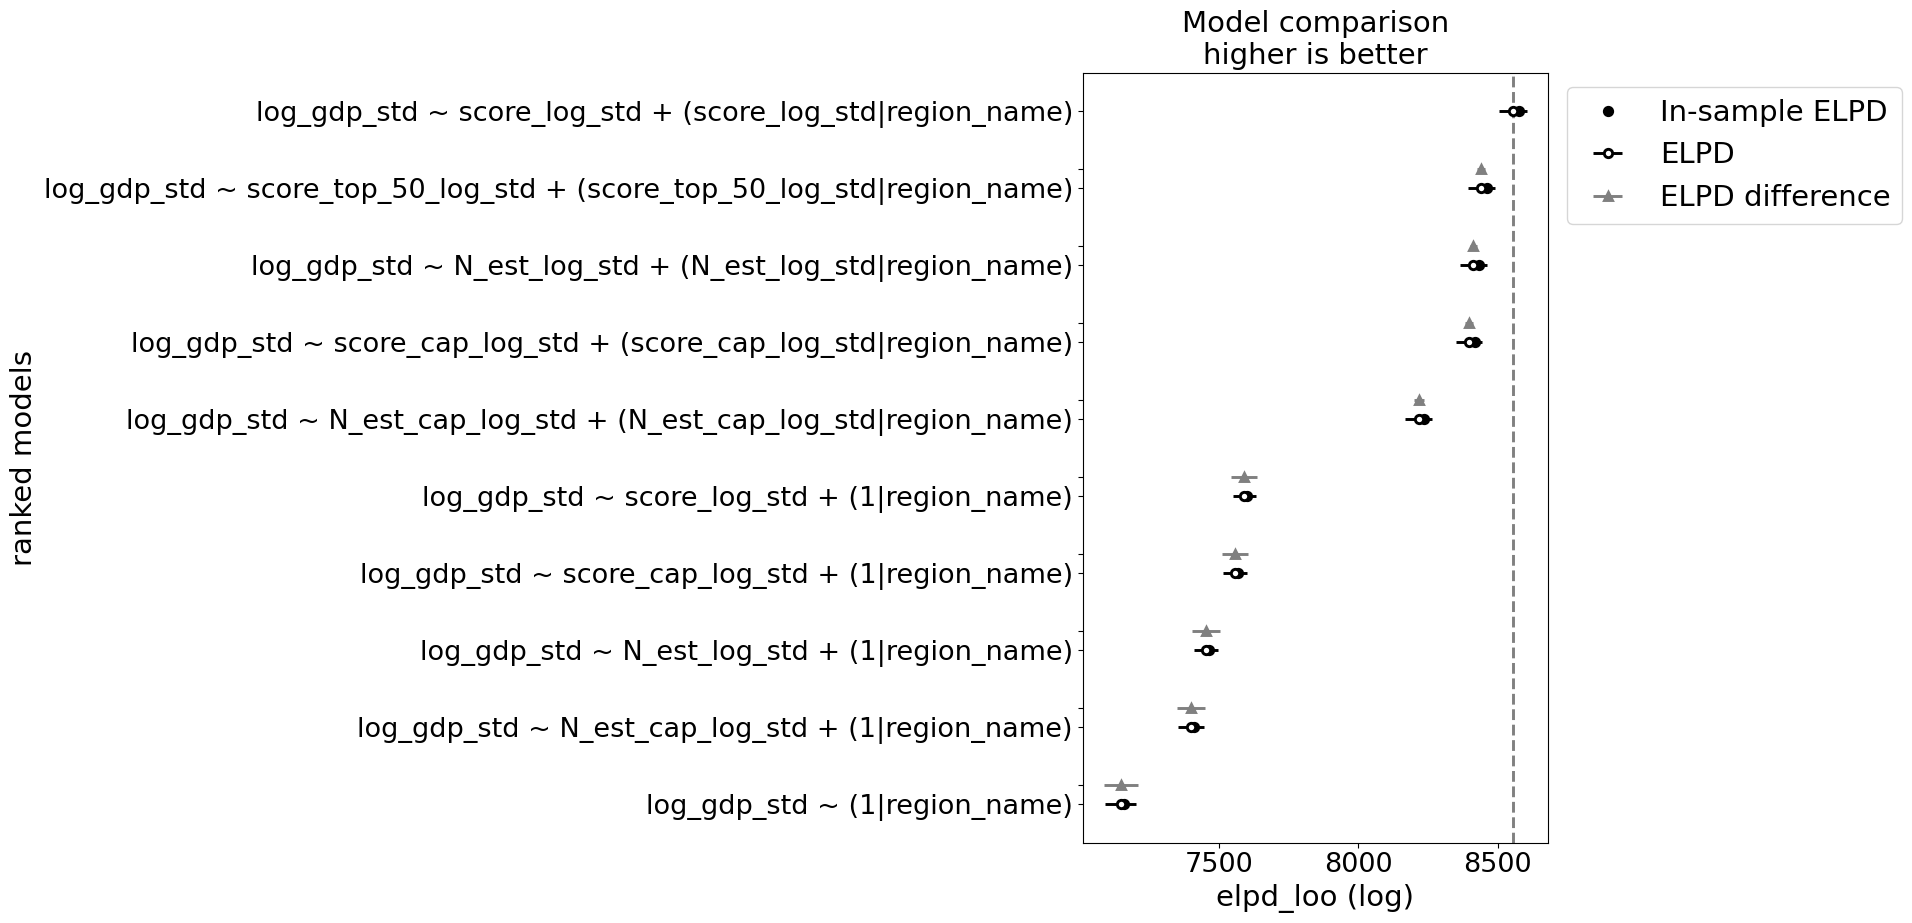

In [134]:
models["log_gdp_std ~ score_top_50_log_std + (score_top_50_log_std|region_name)"] = m_score_vs_top_50_fit
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)

## Top 50% per capita

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

In [ ]:
m_score_vs_top_50_cap = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df_top, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs_top_50_cap

In [ ]:
%%time
m_score_vs_top_50_cap_fit = m_score_vs_top_50_cap.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

In [ ]:
models["log_gdp_std ~ score_cap_top_50_log_std + (score_cap_top_50_log_std|region_name)"] = m_score_vs_top_50_cap_fit

In [ ]:
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)

In [ ]:
"""

# Entries to remove
entries_to_remove = [
    'log_gdp_std ~ score_top_10_log_std + (score_top_10_log_std|region_name)',
    'log_gdp_std ~ score_cap_top_10_log_std + (score_cap_top_10_log_std|region_name)',
]

# Create a new dictionary without the specified entries
filtered_dict = {key: value for key, value in models.items() if key not in entries_to_remove}
"""

In [ ]:
waic_compare = az.compare(filtered_dict, ic='LOO')
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)

## DO NOT TAKE INTO ACCOUNT YET

## Top 10% Global

In [ ]:
new_models = {}

In [ ]:
df_top_10 = pd.read_csv("data/data_stats_filtered_top_10.csv", index_col=0)
df_top_10["region_name_id"] = pd.factorize(df_top_10["region_name"])[0]
print(f"N = {df_top_10.shape[0]}")
df_top_10.sample(5)

# Apply normalization

df_top_10["century"] = df_top_10["year"].round(-2)
df_top_10["score_log"] = np.log(df_top_10["score"])
df_top_10["score_cap_log"] = np.log(df_top_10["score_cap"])
df_top_10["N_est_log"] = np.log(df_top_10["N_est"])
df_top_10["N_est_cap_log"] = np.log(df_top_10["N_est_cap"])
df_top_10["score_log_std"] = df_top_10["score_log"] / df_top_10["score_log"].mean()
df_top_10["score_cap_log_std"] = np.log(df_top_10["score_cap"]) / df_top_10["score_cap_log"].mean()
df_top_10["N_est_log_std"] = df_top_10["N_est_log"] / df_top_10["N_est_log"].mean()
df_top_10["N_est_cap_log_std"] = np.log(df_top_10["N_est_cap"]) / df_top_10["N_est_cap_log"].mean()
df_top_10["log_gdp"] = np.log(df_top_10["gdp_per_capita"])
df_top_10["log_gdp_std"] = df_top_10["log_gdp"] / df_top_10["log_gdp"].mean()
df_top_10.sample(5)

In [ ]:
df_top_10[df_top_10['region_name']=='Japan']

In [ ]:
df_top_50[df_top_50['region_name']=='Japan']

In [ ]:
df_top_50.region_name.value_counts()

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}


m_score_vs_top_10 = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df_top_10, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

m_score_vs_top_10_fit = m_score_vs_top_10.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

In [ ]:
new_models["log_gdp_std ~ score_top_10_log_std + (score_top_10_log_std|region_name)"] = m_score_vs_top_10_fit

## Top 10% per capita

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs_top_10_cap = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df_top_10, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs_top_cap

In [ ]:
%%time
m_score_vs_top_10_cap_fit = m_score_vs_top_10_cap.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

In [ ]:
new_models["log_gdp_std ~ score_cap_top_10_log_std + (score_cap_top_10_log_std|region_name)"] = m_score_vs_top_10_cap_fit

In [ ]:
waic_compare = az.compare(new_models, ic='LOO')
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)